# CS452/CS552 Assignment 2: Car Rollover Prediction

**Release Date: 23.11.2021** <br>
**Submission Deadline: 12.12.2021 23.55**

In [1]:
# Author: Aylin Aydın
# Department: Computer Science
# Degree: BSc.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests as rq
import io
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

pd.set_option('display.max_columns', 150)
random.seed(42) # DO NOT CHANGE
np.random.seed(42) # DO NOT CHANGE

#  Part-2: Exploratory Data Analysis (EDA)

> In this part, explore categorical and numerical features and report some prominent characteristics of data.<br>
Try to get insights from the data for the feature engineering part.<br>

>Before the analysis, inspect the target variable.<br>
Decide on what type of problem is better to learn the car rollover phenomenon by ML models.<br>
Setting problem type is an crucial decision for achievements of ML projects.<br>
**Hint**: You should take an action changing the target variable.<br>
- Detecting missing values, e.g. 0, NaN, 999, -1, representative words (unknown, unavailable, etc.), ...
- Dropping duplicate and empty rows/columns
- histograms, scatter and bar plots
- value counts of categorical features
- statistical tables

In [3]:
# Read the saved final data file as a DataFrame.
# Remark: Your final dataset should comprise approximately 60 columns. 

data = pd.read_csv('FARS.csv')

In [4]:
data=data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.columns

Index(['caseyear', 'statename', 'st_case', 'veh_no', 'vinyear', 'vehtype_t',
       'vinmake_t', 'vinmodel_t', 'bodystyl_t', 'doors', 'wheels', 'drivwhls',
       'mfg_t', 'displci', 'cylndrs', 'fuel_t', 'carbtype', 'shipweight',
       'msrp', 'drivetyp_t', 'drl_t', 'segmnt_t', 'plntctry_t', 'plntcity',
       'origin_t', 'vlvclndr', 'vlvtotal', 'engvincd', 'incomplt', 've_forms',
       'per_no', 'str_veh', 'str_vehname', 'countyname', 'day', 'monthname',
       'hourname', 'sch_busname', 'makename', 'body_typname', 'mod_yearname',
       'tow_vehname', 'spec_usename', 'rollovername', 'age', 'sexname',
       'per_typ', 'seat_posname', 'rest_usename', 'drinkingname', 'drugsname',
       'p_sf1name', 'p_sf2name', 'p_sf3name', 'hispanicname'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452910 entries, 0 to 452909
Data columns (total 55 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   caseyear      452910 non-null  int64  
 1   statename     452910 non-null  object 
 2   st_case       452910 non-null  int64  
 3   veh_no        452910 non-null  int64  
 4   vinyear       437205 non-null  float64
 5   vehtype_t     437205 non-null  object 
 6   vinmake_t     437205 non-null  object 
 7   vinmodel_t    437181 non-null  object 
 8   bodystyl_t    437205 non-null  object 
 9   doors         437205 non-null  float64
 10  wheels        437205 non-null  float64
 11  drivwhls      437205 non-null  float64
 12  mfg_t         426444 non-null  object 
 13  displci       437205 non-null  float64
 14  cylndrs       436492 non-null  object 
 15  fuel_t        402854 non-null  object 
 16  carbtype      371597 non-null  object 
 17  shipweight    437205 non-null  float64
 18  msrp

In [7]:
data.columns.to_series().groupby(data.dtypes).groups

{int64: ['caseyear', 'st_case', 'veh_no', 've_forms', 'per_no', 'str_veh', 'day', 'age', 'per_typ'], float64: ['vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'shipweight', 'msrp', 'vlvclndr', 'vlvtotal'], object: ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'carbtype', 'drivetyp_t', 'drl_t', 'segmnt_t', 'plntctry_t', 'plntcity', 'origin_t', 'engvincd', 'incomplt', 'str_vehname', 'countyname', 'monthname', 'hourname', 'sch_busname', 'makename', 'body_typname', 'mod_yearname', 'tow_vehname', 'spec_usename', 'rollovername', 'sexname', 'seat_posname', 'rest_usename', 'drinkingname', 'drugsname', 'p_sf1name', 'p_sf2name', 'p_sf3name', 'hispanicname']}

In [8]:
# Do not include record identifier columns (e.g. st_case, veh_no, etc.) into the following lists!

categorical = ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 
               'fuel_t', 'carbtype', 'drivetyp_t', 'drl_t', 'segmnt_t', 'plntctry_t', 'plntcity', 
               'origin_t', 'engvincd', 'incomplt', 'str_vehname', 'countyname', 'sch_busname', 
               'makename', 'body_typname', 'mod_yearname', 'tow_vehname', 'spec_usename', 'sexname', 
               'seat_posname', 'rest_usename', 'drinkingname', 'drugsname', 'p_sf1name', 'p_sf2name', 
               'p_sf3name', 'hispanicname','ve_forms',  'per_no', 'man_coll', 'per_typ'] 
                # names of columns having categorical values
numeric = ['caseyear', 'st_case', 'veh_no', 'str_veh', 'age', 'vinyear', 'doors', 'wheels', 'drivwhls', 
           'displci', 'shipweight', 'msrp', 'vlvclndr', 'vlvtotal','cylndrs'] 
                # names of columns having numerical values
target_name = "rollovername" # set the column name of target variable (it is named 'rollovername' in FARS datasets) 

#YOUR CODE HERE

features = categorical + numeric

# Categorical Features

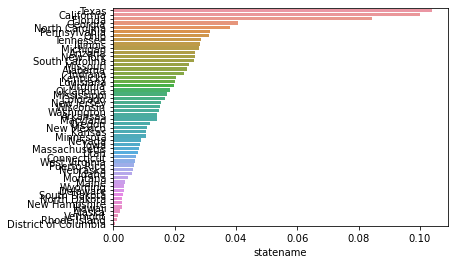

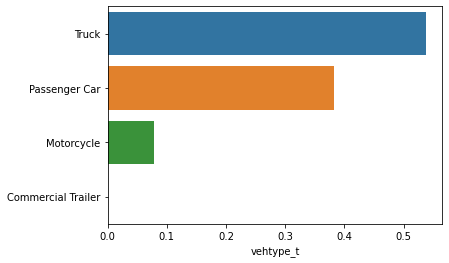

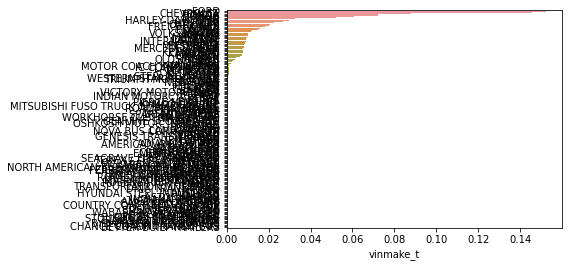

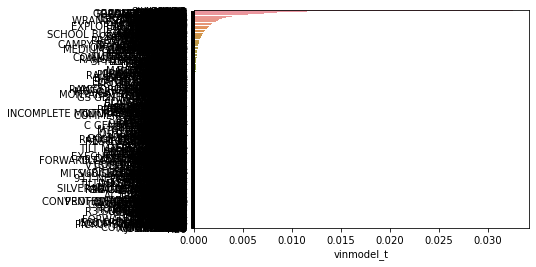

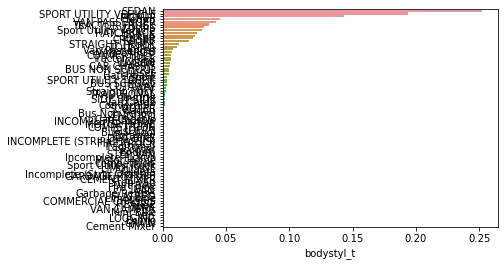

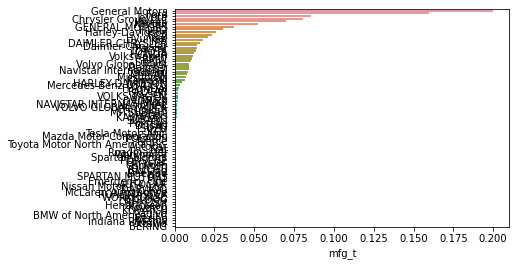

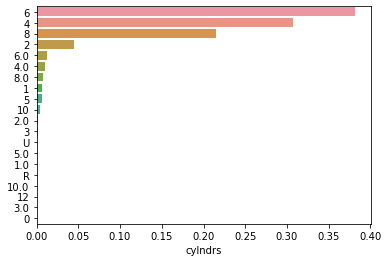

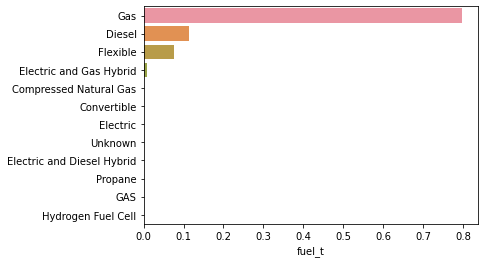

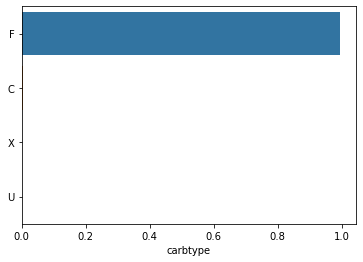

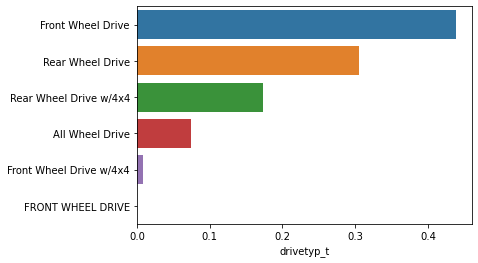

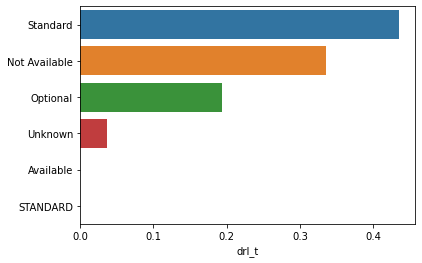

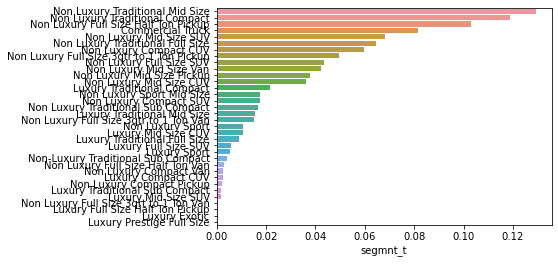

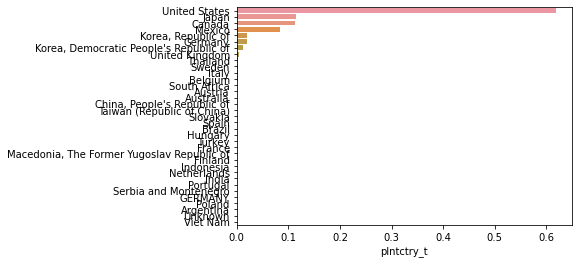

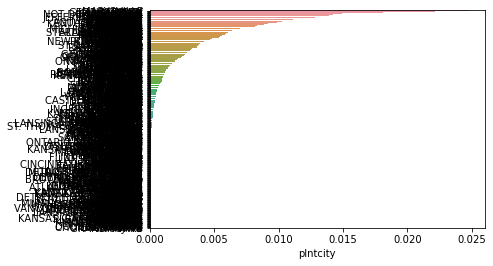

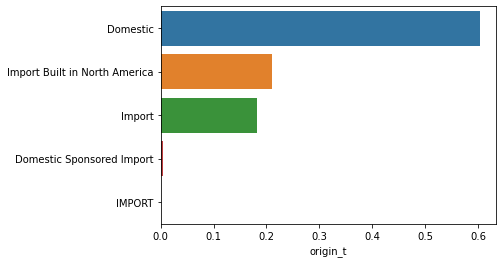

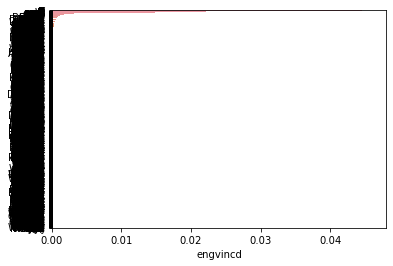

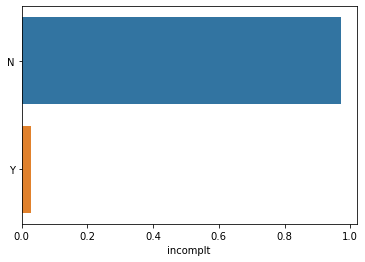

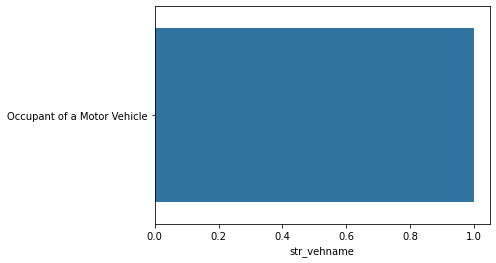

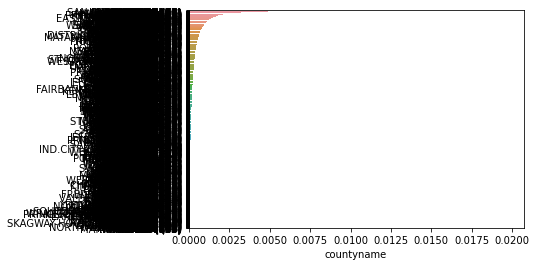

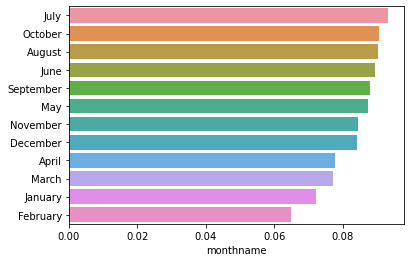

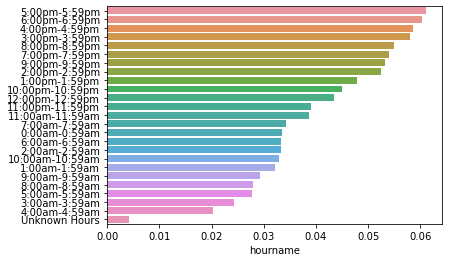

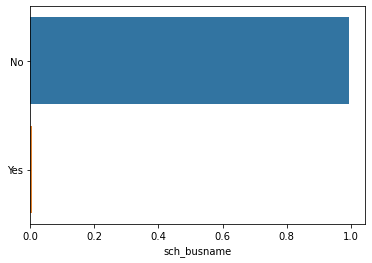

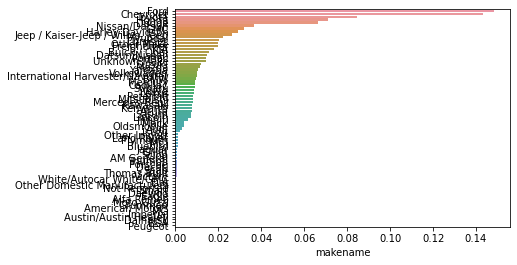

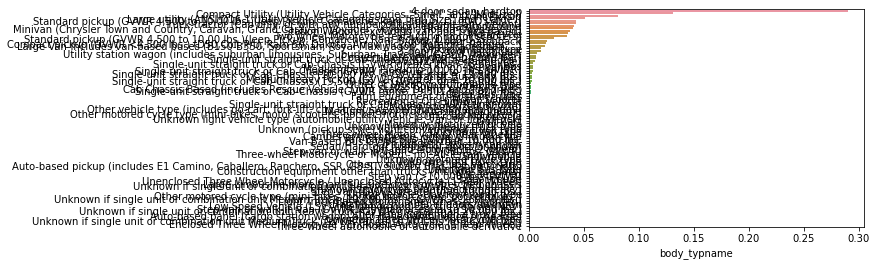

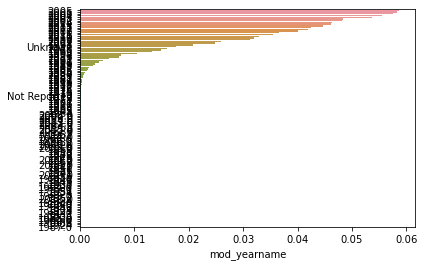

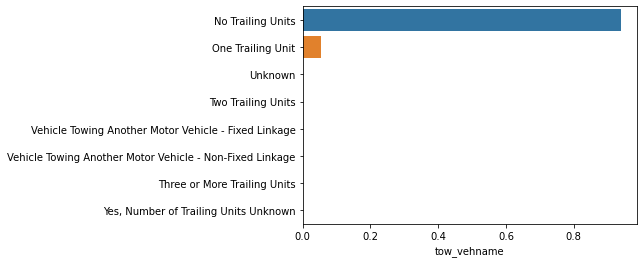

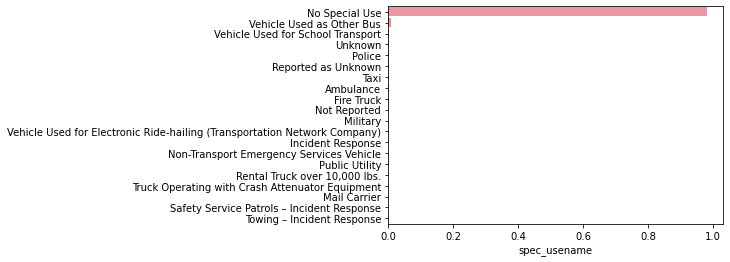

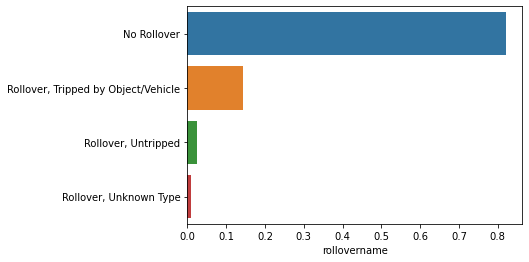

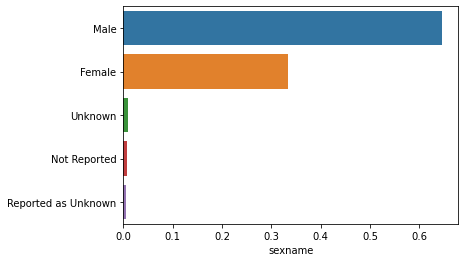

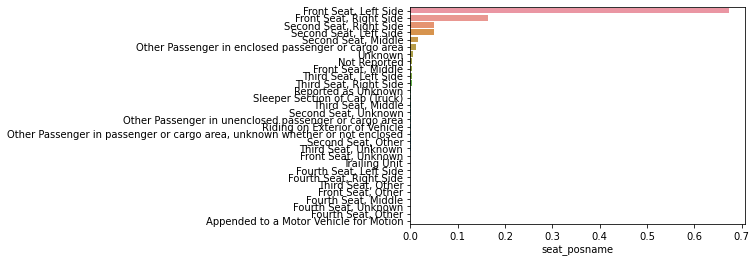

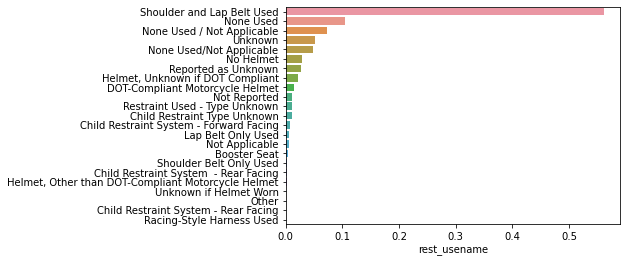

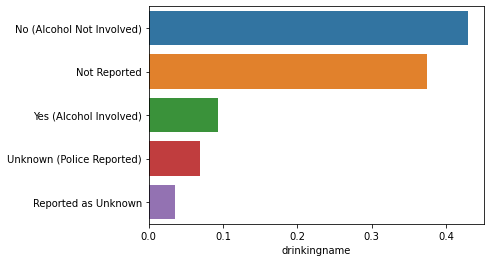

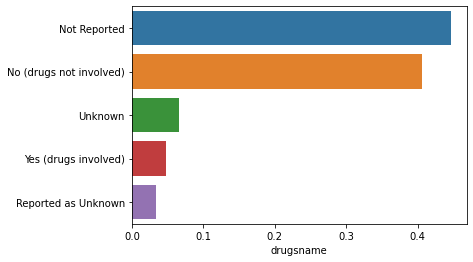

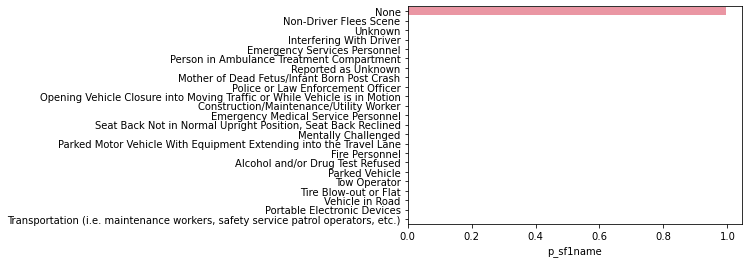

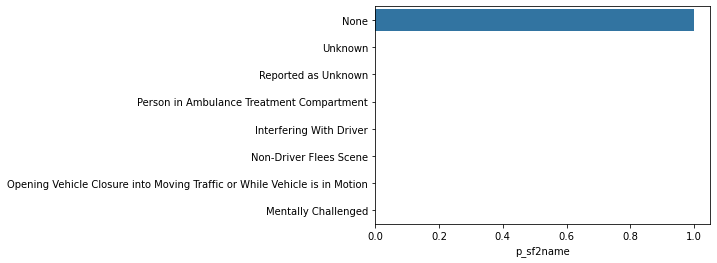

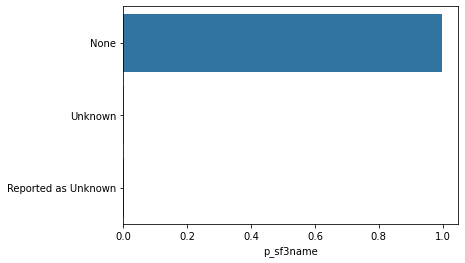

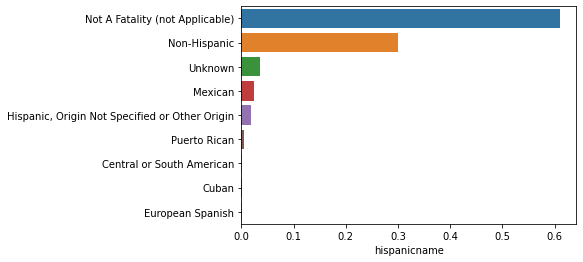

In [9]:
for categorical in data.dtypes[data.dtypes == 'object'].index:
    value_percentages = data[categorical].value_counts(normalize=True, sort=True)
    sns.barplot(x=value_percentages, y=value_percentages.index, orient='h', order=value_percentages.index)
    plt.show()

# Numerical Features

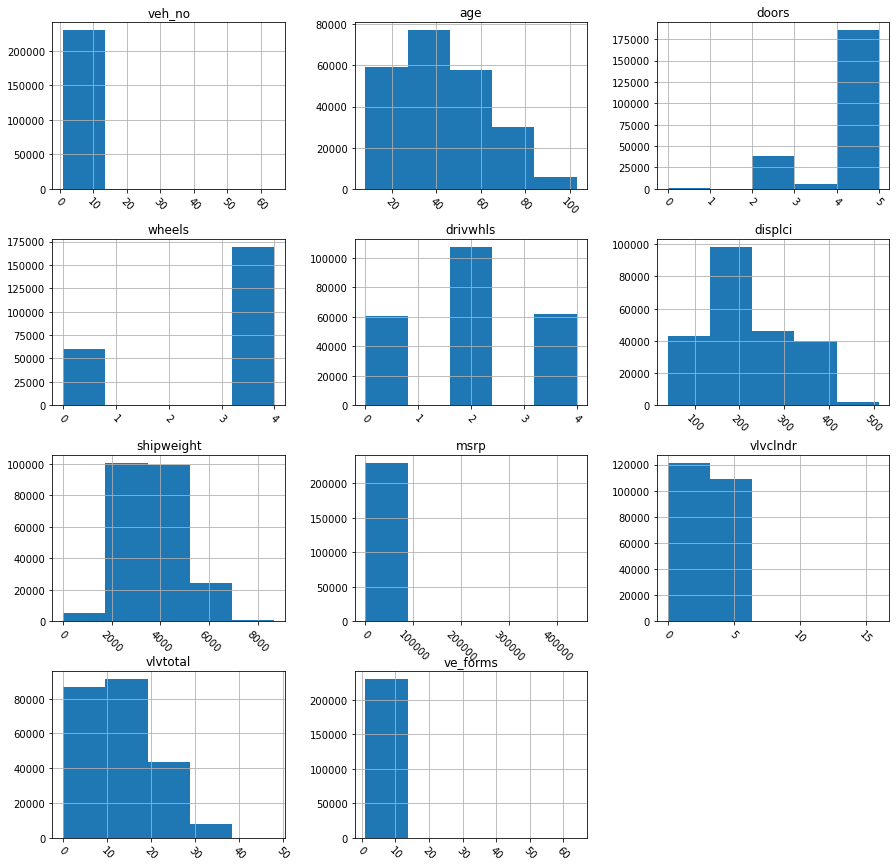

In [270]:
data[numeric].hist(bins=5,figsize=(15,15), xrot=-45)
plt.show()

In [269]:
data["age"].unique()

array([ 24,  52,  22,  20,  81,  29,  46,  35,  33,  39,  71,  74,  61,
        31,  49,  59,  67,  54,  19,  17,  56,  51,  23,  21,  37,  42,
        25,  18,  28,  36,  85,  60,  45,  58,  26,  68,  27,  48,  64,
        44,  47,  78,  69,  57,  40,  53,  43,  87,  72,  84,  50,  65,
        55,  30,  62,  66,  41,  34,  76,  92,  70,  16,  32,  73,  93,
        91,  77,  82,  79,  38,  83,  15,  75,  86,  80,  63,  88,  94,
        89,  90,  97, 100,  95,  96,  13,  98,  14,  99,  12,   9,   8,
       103,  11, 101], dtype=int64)

In [11]:
data.describe()

,caseyear,st_case,veh_no,vinyear,doors,wheels,drivwhls,displci,shipweight,msrp,vlvclndr,vlvtotal,ve_forms,per_no,str_veh,day,age,per_typ
count,452910.000000,452910.000000,452910.000000,437205.000000,437205.000000,437205.000000,437205.000000,437205.000000,437205.000000,437205.000000,437205.000000,437205.000000,452910.000000,452910.000000,452910.0,452910.000000,452910.000000,452910.000000
mean,2016.544993,274467.092740,1.497189,2006.289015,3.117581,2.926737,1.964369,240.925256,3277.621640,22667.913963,1.902137,10.251777,1.960639,1.629229,0.0,15.653706,61.345424,1.344439
std,1.676992,163857.184274,1.228099,6.773508,1.471632,1.936416,1.508930,168.029328,1657.783752,12352.043245,1.857777,10.224284,1.975122,1.798368,0.0,8.799467,146.103571,0.571623
min,2014.000000,10001.000000,1.000000,1981.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000
25%,2015.000000,121929.000000,1.000000,2002.000000,2.000000,0.000000,0.000000,138.000000,2734.000000,16260.000000,0.000000,0.000000,1.000000,1.000000,0.0,8.000000,23.000000,1.000000
50%,2017.000000,270138.000000,1.000000,2006.000000,4.000000,4.000000,2.000000,214.000000,3426.000000,22320.000000,2.000000,12.000000,2.000000,1.000000,0.0,16.000000,36.000000,1.000000
75%,2018.000000,420784.000000,2.000000,2012.000000,4.000000,4.000000,4.000000,293.000000,4320.000000,29060.000000,4.000000,16.000000,2.000000,2.000000,0.0,23.000000,55.000000,2.000000
max,2019.000000,560131.000000,64.000000,2020.000000,5.000000,14.000000,8.000000,1099.000000,14795.000000,441600.000000,16.000000,48.000000,64.000000,57.000000,0.0,31.000000,999.000000,9.000000


In [12]:
len(features)

53

In [13]:
data = data.drop_duplicates()
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,carbtype,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,plntcity,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,per_no,str_veh,str_vehname,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf2name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,1,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,None,Non-Hispanic
1,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,2,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",30,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,None,Not A Fatality (not Applicable)
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,F,4787.0,20775.0,Rear Wheel Drive,Not Available,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,LAGO ALBERTO,Domestic,2.0,16.0,Z,N,1,1,0,Occupant of a Motor Vehicle,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,1,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,None,Not A Fatality (not Applicable)
4,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,2,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,21,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,None,Not A Fatality (not Applicable)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT UTILITY VEHICLE,4.0,4.0,4.0,Hyundai,212.0,6,Gas,F,4120.0,30295.0,All Wheel Drive,Not Available,Non Luxury Mid Size CUV,United States,ALABAMA PLANT,Import Built in North America,4.0,24.0,G,N,1,1,0,Occupant of a Motor Vehicle,LARAMIE (21),22,September,4:00am-4:59am,No,Hyundai,"Compact Utility (Utility Vehicle Categories ""S...",2010,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",31,Male,1,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),None,None,None,Non-Hispan

In [14]:
labels=[]
for i in range(52):
    labels.append(data.iloc[:,i].drop_duplicates())

In [15]:
labels

[0         2014
 67876     2015
 142969    2016
 222207    2017
 300942    2018
 377903    2019
 Name: caseyear, dtype: int64,
 0                     Alabama
 1567                   Alaska
 1729                  Arizona
 3364                 Arkansas
 4379               California
 11023                Colorado
 12058             Connecticut
 12522                Delaware
 12819    District of Columbia
 12854                 Florida
 17976                 Georgia
 20339                  Hawaii
 20522                   Idaho
 20892                Illinois
 22830                 Indiana
 24453                    Iowa
 25083                  Kansas
 25850                Kentucky
 27191               Louisiana
 28608                   Maine
 28845                Maryland
 29767           Massachusetts
 30413                Michigan
 32255               Minnesota
 33049             Mississippi
 34235                Missouri
 35841                 Montana
 36202                Nebraska
 3664

In [16]:
len(data[data["carbtype"]=='F'])
#most of carbtypes are F 

369878

In [17]:
missing = [0, 0.0,"NaN", 999, -1, "Unknown","None","Not Reported","Not Available"
                  ,'Reported as Unknown','Unknown Type','N']

In [18]:
data=data.drop(['p_sf2name'], axis=1)

In [19]:
data.isnull().sum().sort_values(ascending=False)

drl_t           90162
carbtype        81313
drivetyp_t      50501
fuel_t          50056
segmnt_t        49973
engvincd        43976
mfg_t           26466
plntcity        26003
plntctry_t      20400
origin_t        16499
cylndrs         16418
vinmodel_t      15729
shipweight      15705
incomplt        15705
vlvtotal        15705
vlvclndr        15705
msrp            15705
vinmake_t       15705
vinyear         15705
displci         15705
doors           15705
wheels          15705
drivwhls        15705
bodystyl_t      15705
vehtype_t       15705
p_sf3name           0
p_sf1name           0
drugsname           0
body_typname        0
drinkingname        0
rest_usename        0
seat_posname        0
per_typ             0
sexname             0
age                 0
rollovername        0
spec_usename        0
tow_vehname         0
mod_yearname        0
caseyear            0
makename            0
sch_busname         0
hourname            0
monthname           0
day                 0
countyname

In [20]:
corr = data.corr(method="pearson")
corr

,caseyear,st_case,veh_no,vinyear,doors,wheels,drivwhls,displci,shipweight,msrp,vlvclndr,vlvtotal,ve_forms,per_no,str_veh,day,age,per_typ
caseyear,1.000000,-0.014256,0.008939,0.223277,0.023717,0.074792,0.064072,-0.009497,0.021730,0.061890,0.097066,0.086945,0.010815,-0.020810,NaN,-0.001669,0.011147,-0.016565
st_case,-0.014256,1.000000,0.004320,-0.006639,-0.006491,0.012598,0.040912,0.038575,0.014232,-0.007389,-0.026112,-0.021679,0.005829,0.007759,NaN,-0.001979,-0.027960,-0.006546
veh_no,0.008939,0.004320,1.000000,0.105499,-0.001384,0.081648,0.071643,0.065994,0.000171,0.008999,0.049186,0.042420,0.790053,0.007287,NaN,-0.004118,-0.005723,0.018058
vinyear,0.223277,-0.006639,0.105499,1.000000,0.065634,0.294603,0.205027,0.007019,0.037119,0.193621,0.408031,0.348115,0.095856,-0.005291,NaN,0.008921,0.013615,0.005126
doors,0.023717,-0.006491,-0.001384,0.065634,1.000000,0.094619,0.133404,-0.315627,0.710310,0.559098,0.459241,0.432381,0.002992,-0.006432,NaN,-0.001573,0.012106,0.130090
wheels,0.074792,0.012598,0.081648,0.294603,0.094619,1.000000,0.854428,0.500256,0.218050,0.077355,0.190560,0.133681,0.063551,0.092338,NaN,0.004264,0.021853,0.046733
drivwhls,0.064072,0.040912,0.071643,0.205027,0.133404,0.854428,1.000000,0.485086,0.330296,0.211809,0.105989,0.098131,0.052203,0.031017,NaN,-0.000274,0.021567,0.034213
displci,-0.009497,0.038575,0.065994,0.007019,-0.315627,0.500256,0.485086,1.000000,-0.088123,-0.149537,-0.279836,-0.192039,0.051471,0.053351,NaN,-0.001273,0.017121,-0.015055
shipweight,0.021730,0.014232,0.000171,0.037119,0.710310,0.218050,0.330296,-0.088123,1.000000,0.717492,0.271341,0.338483,-0.007517,0.016374,NaN,-0.002725,0.013947,0.118207
msrp,0.061890,-0.007389,0.008999,0.193621,0.559098,0.077355,0.211809,-0.149537,0.717492,1.000000,0.292153,0.407454,0.003626,-0.005752,NaN,-0.003231,0.019805,0.095715


In [21]:
target=data[target_name]
target

0         Rollover, Tripped by Object/Vehicle
1         Rollover, Tripped by Object/Vehicle
2                                 No Rollover
3                                 No Rollover
4                                 No Rollover
                         ...                 
452905    Rollover, Tripped by Object/Vehicle
452906    Rollover, Tripped by Object/Vehicle
452907                            No Rollover
452908                            No Rollover
452909                            No Rollover
Name: rollovername, Length: 452910, dtype: object

In [22]:
target=pd.DataFrame(target)
target

,rollovername
0,"Rollover, Tripped by Object/Vehicle"
1,"Rollover, Tripped by Object/Vehicle"
2,No Rollover
3,No Rollover
4,No Rollover
...,...
452905,"Rollover, Tripped by Object/Vehicle"
452906,"Rollover, Tripped by Object/Vehicle"
452907,No Rollover
452908,No Rollover


In [23]:
# YOUR CODE HERE

In [24]:
encodedTarget=pd.get_dummies(target[["rollovername"]])

In [25]:
encodedTarget

,rollovername_No Rollover,"rollovername_Rollover, Tripped by Object/Vehicle","rollovername_Rollover, Unknown Type","rollovername_Rollover, Untripped"
0,0,1,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
452905,0,1,0,0
452906,0,1,0,0
452907,1,0,0,0
452908,1,0,0,0


In [26]:
encoder=OneHotEncoder(sparse=False)

mydf=pd.DataFrame(encoder.fit_transform(target[['rollovername']]))

In [27]:
mydf

,0,1,2,3
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
452905,0.0,1.0,0.0,0.0
452906,0.0,1.0,0.0,0.0
452907,1.0,0.0,0.0,0.0
452908,1.0,0.0,0.0,0.0


#  Part-3: Data Cleaning and Feature Engineering

### 3.1. Handling with Missing Values: Dropping and/or Imputation
> You may drop some rows and columns.<br>
> Imputation with statistical values (mean, median, mode)<br>
> Imputation with a keyword like missing, unknown, etc.<br>

In [28]:
# YOUR CODE HERE

In [29]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,carbtype,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,plntcity,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,per_no,str_veh,str_vehname,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,1,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
1,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,2,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",30,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,F,4787.0,20775.0,Rear Wheel Drive,Not Available,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,LAGO ALBERTO,Domestic,2.0,16.0,Z,N,1,1,0,Occupant of a Motor Vehicle,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,1,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
4,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,2,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,21,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT UTILITY VEHICLE,4.0,4.0,4.0,Hyundai,212.0,6,Gas,F,4120.0,30295.0,All Wheel Drive,Not Available,Non Luxury Mid Size CUV,United States,ALABAMA PLANT,Import Built in North America,4.0,24.0,G,N,1,1,0,Occupant of a Motor Vehicle,LARAMIE (21),22,September,4:00am-4:59am,No,Hyundai,"Compact Utility (Utility Vehicle Categories ""S...",2010,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",31,Male,1,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),None,None,Non-Hispanic
452906,2019,Wyoming,560120,1,2010.0,Truck

In [30]:
data=data[data['doors'].notna()]

In [31]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,carbtype,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,plntcity,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,per_no,str_veh,str_vehname,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,1,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
1,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,Standard,Non Luxury Traditional Compact,Canada,CAMBRIDGE,Import Built in North America,4.0,16.0,U,N,1,2,0,Occupant of a Motor Vehicle,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",30,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,F,4787.0,20775.0,Rear Wheel Drive,Not Available,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,LAGO ALBERTO,Domestic,2.0,16.0,Z,N,1,1,0,Occupant of a Motor Vehicle,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,1,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
4,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,Standard,Non Luxury Traditional Mid Size,United States,FAIRFAX,Domestic,0.0,0.0,8,N,2,2,0,Occupant of a Motor Vehicle,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,21,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT UTILITY VEHICLE,4.0,4.0,4.0,Hyundai,212.0,6,Gas,F,4120.0,30295.0,All Wheel Drive,Not Available,Non Luxury Mid Size CUV,United States,ALABAMA PLANT,Import Built in North America,4.0,24.0,G,N,1,1,0,Occupant of a Motor Vehicle,LARAMIE (21),22,September,4:00am-4:59am,No,Hyundai,"Compact Utility (Utility Vehicle Categories ""S...",2010,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",31,Male,1,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),None,None,Non-Hispanic
452906,2019,Wyoming,560120,1,2010.0,Truck

In [32]:
data.isnull().sum().sort_values(ascending=False)

drl_t           74457
carbtype        65608
drivetyp_t      34796
fuel_t          34351
segmnt_t        34268
engvincd        28271
mfg_t           10761
plntcity        10298
plntctry_t       4695
origin_t          794
cylndrs           713
vinmodel_t         24
rest_usename        0
p_sf3name           0
monthname           0
hourname            0
sch_busname         0
makename            0
body_typname        0
mod_yearname        0
drugsname           0
p_sf1name           0
tow_vehname         0
spec_usename        0
countyname          0
drinkingname        0
rollovername        0
age                 0
sexname             0
per_typ             0
seat_posname        0
day                 0
caseyear            0
str_vehname         0
drivwhls            0
st_case             0
veh_no              0
vinyear             0
vehtype_t           0
vinmake_t           0
bodystyl_t          0
doors               0
wheels              0
displci             0
str_veh             0
shipweight

In [33]:
data["str_vehname"].unique()

data=data.drop(["str_vehname"], axis=1)

In [276]:
data["drl_t"].unique()

data["drl_t"]=data["drl_t"].str.upper()

data['drl_t'] = data['drl_t'].fillna('NOT AVAILABLE')

<ipython-input-276-02785152a268>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["drl_t"]=data["drl_t"].str.upper()
<ipython-input-276-02785152a268>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['drl_t'] = data['drl_t'].fillna('NOT AVAILABLE')


In [277]:
data['drl_t'].replace(['NOT AVAILABLE', 'UNKNOWN'],'STANDARD',inplace=True)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [278]:
data["drl_t"].unique()

array(['STANDARD', 'OPTIONAL', 'AVAILABLE'], dtype=object)

In [37]:
data["drivetyp_t"].unique()

print(data["drivetyp_t"].mode())

data["drivetyp_t"] = data["drivetyp_t"].fillna('Front Wheel Drive')

0    Front Wheel Drive
dtype: object


In [38]:
data["fuel_t"].unique()

print(data["fuel_t"].mode())

data["fuel_t"] = data["fuel_t"].fillna('Gas')

0    Gas
dtype: object


In [39]:
data["segmnt_t"].unique()

data["segmnt_t"].mode()

data["segmnt_t"] = data["segmnt_t"].fillna('Non Luxury Traditional Mid Size')

In [40]:
data["engvincd"].unique()

data["engvincd"].mode()

data["engvincd"] = data["engvincd"].fillna('K')

In [41]:
data["mfg_t"].unique()

data["mfg_t"].mode()

data[data["mfg_t"]=='Toyota']

data["mfg_t"]=data["mfg_t"].str.upper()

data.replace(['TOYOTA MOTOR NORTH AMERICA INC.'],'TOYOTA', inplace=True)

data.replace(['NISSAN MOTOR CO. LTD.'],'NISSAN', inplace=True)
data.replace(['CHRYSLER GROUP LLC','CHRYSLER','DAIMLER'],'DAIMLER-CHRYSLER', inplace=True)
data.replace(['NISSAN MOTOR CO. LTD.'],'NISSAN', inplace=True)

data["mfg_t"].mode()

data["mfg_t"] = data["mfg_t"].fillna('GENERAL MOTORS')

In [42]:
data["plntcity"].unique()

data=data.drop(["plntcity"], axis=1)

data["plntctry_t"] = data["plntctry_t"].fillna('United States')

In [43]:
data["plntctry_t"].unique()

array(['Canada', 'Mexico', 'United States', 'Japan', 'Korea, Republic of',
       "Korea, Democratic People's Republic of", 'Belgium',
       'United Kingdom', 'Germany', 'Thailand', 'Italy', 'Austria',
       'South Africa', 'Serbia and Montenegro', 'Australia', 'Hungary',
       'Brazil', 'Indonesia', 'Sweden', 'Taiwan (Republic of China)',
       'Spain', 'Finland', 'Netherlands', 'France', 'Turkey', 'Slovakia',
       "China, People's Republic of", 'Portugal', 'GERMANY', 'India',
       'Macedonia, The Former Yugoslav Republic of', 'Unknown',
       'Viet Nam', 'Poland', 'Argentina'], dtype=object)

In [44]:
data["plntctry_t"].mode()

0    United States
dtype: object

In [45]:
data['drl_t'].replace(['NOT AVAILABLE', 'UNKNOWN'],'STANDARD',inplace=True)

In [46]:
data["origin_t"].mode()

0    Domestic
dtype: object

In [47]:
data["origin_t"].unique()

data["origin_t"]=data["origin_t"].str.lower()

data["origin_t"] = data["origin_t"].fillna('domestic')

data["origin_t"].unique()

array(['import built in north america', 'domestic', 'import',
       'domestic sponsored import'], dtype=object)

In [48]:
data["cylndrs"].unique()

array(['4.0', '8.0', '6.0', '5.0', '2.0', '1.0', '3.0', '10.0', nan, '6',
       '8', '4', '2', 'R', '1', '5', '3', '12', '10', 'U', '0'],
      dtype=object)

In [49]:
#data[data["cylndrs"] == '4'] = data["cylndrs"]= '4.0'

In [50]:
data["cylndrs"].unique()

array(['4.0', '8.0', '6.0', '5.0', '2.0', '1.0', '3.0', '10.0', nan, '6',
       '8', '4', '2', 'R', '1', '5', '3', '12', '10', 'U', '0'],
      dtype=object)

In [51]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,carbtype,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,per_no,str_veh,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,N,1,1,0,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
1,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,F,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,N,1,2,0,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",30,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,F,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,Z,N,1,1,0,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,N,2,1,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
4,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,F,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,N,2,2,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,21,Female,2,"Front Seat, Right Side",Shoulder and Lap Belt Used,Not Reported,Not Reported,None,None,Not A Fatality (not Applicable)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT UTILITY VEHICLE,4.0,4.0,4.0,HYUNDAI,212.0,6,Gas,F,4120.0,30295.0,All Wheel Drive,STANDARD,Non Luxury Mid Size CUV,United States,import built in north america,4.0,24.0,G,N,1,1,0,LARAMIE (21),22,September,4:00am-4:59am,No,Hyundai,"Compact Utility (Utility Vehicle Categories ""S...",2010,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",31,Male,1,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),None,None,Non-Hispanic
452906,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT UTILITY VEHICLE,4.0,4.0,4.0,HYUNDAI,212.0,6,Gas,F,4120.0,30295.0,All Wheel Drive,STANDARD,Non Luxury Mid Size CUV,United States,import built in north america,4.0,24.0,G,N,1,2,0,LARAMIE (21),22,September,4:00am-4:59am,No,Hyundai,"Compact Utility (

In [52]:
data["carbtype"].unique()

array(['F', nan, 'C', 'X', 'U'], dtype=object)

In [53]:
len(data[data["carbtype"]=='F'])
#most of carbtypes are F and most of the rest are empty

369878

In [54]:
data=data.drop(["carbtype"], axis=1)

In [55]:
data["vinmodel_t"].unique()

array(['COROLLA', 'RAM 2500', 'MALIBU', ..., 'CX650', 'RVR', 'INT 650'],
      dtype=object)

In [56]:
data["vinmodel_t"].mode()

0    SILVERADO
dtype: object

In [57]:
len(data["vinmodel_t"].unique())

2112

In [58]:
data.dropna(inplace=True)

In [59]:
data.isnull().sum().sort_values(ascending=False)

caseyear        0
tow_vehname     0
per_no          0
str_veh         0
countyname      0
day             0
monthname       0
hourname        0
sch_busname     0
makename        0
body_typname    0
mod_yearname    0
spec_usename    0
incomplt        0
rollovername    0
age             0
sexname         0
per_typ         0
seat_posname    0
rest_usename    0
drinkingname    0
drugsname       0
p_sf1name       0
p_sf3name       0
ve_forms        0
engvincd        0
statename       0
mfg_t           0
st_case         0
veh_no          0
vinyear         0
vehtype_t       0
vinmake_t       0
vinmodel_t      0
bodystyl_t      0
doors           0
wheels          0
drivwhls        0
displci         0
vlvtotal        0
cylndrs         0
fuel_t          0
shipweight      0
msrp            0
drivetyp_t      0
drl_t           0
segmnt_t        0
plntctry_t      0
origin_t        0
vlvclndr        0
hispanicname    0
dtype: int64

In [60]:
data=data[data["per_no"]==1]

In [61]:
data=data.drop(["per_no"], axis=1)

In [62]:
data.columns

Index(['caseyear', 'statename', 'st_case', 'veh_no', 'vinyear', 'vehtype_t',
       'vinmake_t', 'vinmodel_t', 'bodystyl_t', 'doors', 'wheels', 'drivwhls',
       'mfg_t', 'displci', 'cylndrs', 'fuel_t', 'shipweight', 'msrp',
       'drivetyp_t', 'drl_t', 'segmnt_t', 'plntctry_t', 'origin_t', 'vlvclndr',
       'vlvtotal', 'engvincd', 'incomplt', 've_forms', 'str_veh', 'countyname',
       'day', 'monthname', 'hourname', 'sch_busname', 'makename',
       'body_typname', 'mod_yearname', 'tow_vehname', 'spec_usename',
       'rollovername', 'age', 'sexname', 'per_typ', 'seat_posname',
       'rest_usename', 'drinkingname', 'drugsname', 'p_sf1name', 'p_sf3name',
       'hispanicname'],
      dtype='object')

In [63]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,str_veh,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,Sedan,4.0,4.0,2.0,TOYOTA,110.000000,4.0,Gas,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,N,1,0,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.000000,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,Z,N,1,0,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.000000,6.0,Gas,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,N,2,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
7,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAMRY,Sedan,4.0,0.0,0.0,TOYOTA,183.000000,6.0,Gas,3086.0,19248.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,import built in north america,4.0,24.0,F,N,2,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Toyota,"4-door sedan, hardtop",1997,No Trailing Units,No Special Use,No Rollover,20,Female,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
10,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TACOMA,Pickup,2.0,4.0,2.0,TOYOTA,149.000000,4.0,Gas,2567.0,12698.0,Rear Wheel Drive,STANDARD,Non Luxury Mid Size Pickup,United States,import built in north america,0.0,0.0,L,N,3,0,TALLADEGA (121),2,January,9:00am-9:59am,No,Toyota,"Compact pickup (GVWR <4,500 lbs.) (D50,Colt P/...",1999,No Trailing Units,No Special Use,No Rollover,81,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452903,2019,Wyoming,560118,5,2000.0,Truck,PETERBILT,379,TRACTOR TRUCK,0.0,6.0,4.0,PACCAR,893.000000,6,Diesel,0.0,0.0,Rear Wheel Drive,Not Available,Commercial Truck,United States,domestic,0.0,0.0,B,N,5,0,ALBANY (1),30,September,1:00pm-1:59pm,No,Peterbilt,"Truck-tractor (Cab only, or with any number of...",2000,One Trailing Unit,No Special Use,"Rollover, Tripped by Object/Vehicle",56,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,No (Alcohol Not Involved),No (drugs not involved),None,None,Not A Fatality (not Applicable)
452904,2019,Wyoming,560119,1,2018.0,Motorcycle,HARLEY-DAVIDSON,FLHXSE,TOURING,0.0,0.0,0.0,HARLEY-DAVIDSON,117.073171,2,Gas,842.0,39949.0,Front Wheel Drive,Not Available,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,K,N,1,0,SHERIDAN (33),22,September,3:00pm-3:59pm,No,Harley-Davidson,Two Wheel Motorcycle (excluding motor scooters),2018,No Trailing Units,No Speci

### 3.2. Reducing cardinality of categorical features 
> Some categorical features have a cardinality which will cause to have lots of dummy variables. <br>
> Therefore, it is certainly needed to do some operations on that features. You may even consider dropping some of them. <br>
> Be aware of some risk of information loss caused by operations done in this part.<br>
> **Hint**: There are 37 different values for *bodystyl_t* feature which means vehicle body type. You can map the values into some higher level categories like [TRUCK, VAN, BUS, SPORT, STANDARD, OTHER, ...]. <br>
> You can also utilize [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023) for this step.

In [64]:
# YOUR CODE HERE
data["bodystyl_t"].unique()

array(['Sedan', 'Pickup', 'Van Passenger', 'Tractor Truck', 'Hatchback',
       'Coupe', 'Sport Utility Vehicle', 'Straight Truck', 'Sport',
       'Van Cargo', 'Convertible', 'Cruiser', 'Bus Non School', 'ATV',
       'Cab Chassis', 'Touring', 'Traditional', 'Scooter',
       'Sport Utility Truck', 'Wagon', 'Incomplete Pickup', 'Motor Home',
       'Dirt Bike', 'Competition', 'Cutaway', 'Bus School',
       'Incomplete (Strip Chassis)', 'Enduro', 'Gliders', 'Step Van',
       'Garbage/Refuse', 'Mini Bike', 'Fire Truck', 'Cement Mixer',
       'Limousine', 'PICKUP', 'SEDAN', 'HATCHBACK', 'STRAIGHT TRUCK',
       'SPORT UTILITY VEHICLE', 'VAN CARGO', 'CONVERTIBLE',
       'VAN PASSENGER', 'CRUISER', 'TRACTOR TRUCK', 'WAGON', 'SPORT',
       'COUPE', 'SPORT UTILITY TRUCK', 'CAB CHASSIS', 'BUS SCHOOL',
       'CUTAWAY', 'TOURING', 'SCOOTER', 'ENDURO', 'COMPETITION',
       'INCOMPLETE PICKUP', 'SIDE BY SIDE', 'MOTOR HOME',
       'BUS NON SCHOOL', 'TRADITIONAL', 'INCOMPLETE (STRIP CHASSIS

In [65]:
data["bodystyl_t"]=data["bodystyl_t"].str.upper()


In [66]:
data.replace(['TRACTOR TRUCK','STRAIGHT TRUCK','SPORT UTILITY TRUCK','FIRE TRUCK','CEMENT MIXER','GARBAGE/REFUSE','CAB CHASSIS','COMMERCIAL CHASSIS','PICKUP'],"TRUCK", inplace=True)

data.replace(['VAN PASSENGER','VAN CARGO','STEP VAN','VAN CAMPER','WAGON'],'VAN', inplace=True)

data.replace(['BUS NON SCHOOL','BUS SCHOOL'],'BUS', inplace=True)

data.replace(['SPORT UTILITY VEHICLE','SPORT','SPORT UTILITY TRUCK'],'SPORT', inplace=True)

data.replace(['INCOMPLETE (STRIP CHASSIS)','INCOMPLETE PICKUP'],'INCOMPLETE', inplace=True)

data.replace(['ATV','DIRT BIKE','MINI BIKE','SCOOTER','TOURING'],'FUN CAR', inplace=True)

data.replace(['SEDAN','HATCHBACK'],'CAR', inplace=True)

data.replace(['TRADITIONAL','MOTOR HOME','COMPETITION','CUTAWAY','ENDURO', 'GLIDERS', 'LIMOUSINE',
       'SIDE BY SIDE', 'HEARSE', 'CONVERTIBLE', 'CRUISER'],'OTHER', inplace=True)

In [67]:
data["bodystyl_t"].unique()

array(['CAR', 'TRUCK', 'VAN', 'COUPE', 'SPORT', 'OTHER', 'BUS', 'FUN CAR',
       'INCOMPLETE'], dtype=object)

In [68]:
data["cylndrs"].unique()

array(['4.0', '8.0', '6.0', '5.0', '2.0', '1.0', '3.0', '10.0', '6', '8',
       '4', '2', 'R', '1', '5', '3', '12', '10', 'U', '0'], dtype=object)

In [69]:
data["cylndrs"].replace(['1'],'1.0',inplace=True)
data["cylndrs"].replace(['2'],'2.0',inplace=True)
data["cylndrs"].replace(['3'],'3.0',inplace=True)
data["cylndrs"].replace(['4'],'4.0',inplace=True)
data["cylndrs"].replace(['5'],'5.0',inplace=True)
data["cylndrs"].replace(['6'],'6.0',inplace=True)
data["cylndrs"].replace(['8'],'8.0',inplace=True)
data["cylndrs"].replace(['10'],'10.0',inplace=True)
data["cylndrs"].replace(['12'],'12.0',inplace=True)

In [70]:
data=data[data["cylndrs"]!='U']
data=data[data["cylndrs"]!='0']

In [71]:
data["cylndrs"].unique()

array(['4.0', '8.0', '6.0', '5.0', '2.0', '1.0', '3.0', '10.0', 'R',
       '12.0'], dtype=object)

In [72]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,engvincd,incomplt,ve_forms,str_veh,countyname,day,monthname,hourname,sch_busname,makename,body_typname,mod_yearname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,CAR,4.0,4.0,2.0,TOYOTA,110.000000,4.0,Gas,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,N,1,0,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",2011,No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.000000,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,Z,N,1,0,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997,No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.000000,6.0,Gas,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,N,2,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",2004,No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
7,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAMRY,CAR,4.0,0.0,0.0,TOYOTA,183.000000,6.0,Gas,3086.0,19248.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,import built in north america,4.0,24.0,F,N,2,0,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Toyota,"4-door sedan, hardtop",1997,No Trailing Units,No Special Use,No Rollover,20,Female,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
10,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TACOMA,TRUCK,2.0,4.0,2.0,TOYOTA,149.000000,4.0,Gas,2567.0,12698.0,Rear Wheel Drive,STANDARD,Non Luxury Mid Size Pickup,United States,import built in north america,0.0,0.0,L,N,3,0,TALLADEGA (121),2,January,9:00am-9:59am,No,Toyota,"Compact pickup (GVWR <4,500 lbs.) (D50,Colt P/...",1999,No Trailing Units,No Special Use,No Rollover,81,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452903,2019,Wyoming,560118,5,2000.0,Truck,PETERBILT,379,TRUCK,0.0,6.0,4.0,PACCAR,893.000000,6.0,Diesel,0.0,0.0,Rear Wheel Drive,Not Available,Commercial Truck,United States,domestic,0.0,0.0,B,N,5,0,ALBANY (1),30,September,1:00pm-1:59pm,No,Peterbilt,"Truck-tractor (Cab only, or with any number of...",2000,One Trailing Unit,No Special Use,"Rollover, Tripped by Object/Vehicle",56,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,No (Alcohol Not Involved),No (drugs not involved),None,None,Not A Fatality (not Applicable)
452904,2019,Wyoming,560119,1,2018.0,Motorcycle,HARLEY-DAVIDSON,FLHXSE,FUN CAR,0.0,0.0,0.0,HARLEY-DAVIDSON,117.073171,2.0,Gas,842.0,39949.0,Front Wheel Drive,Not Available,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,K,N,1,0,SHERIDAN (33),22,September,3:00pm-3:59pm,No,Harley-Davidson,Two Wheel Motorcycle (excluding motor scooters),2018,No Trailing Units,No Special Use,No Ro

In [73]:
data=data.drop(["incomplt"], axis=1)

In [74]:
data=data.drop(["str_veh"], axis=1)

In [75]:
data=data.drop(["mod_yearname"], axis=1)

In [76]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,engvincd,ve_forms,countyname,day,monthname,hourname,sch_busname,makename,body_typname,tow_vehname,spec_usename,rollovername,age,sexname,per_typ,seat_posname,rest_usename,drinkingname,drugsname,p_sf1name,p_sf3name,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,CAR,4.0,4.0,2.0,TOYOTA,110.000000,4.0,Gas,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,1,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,None,None,Non-Hispanic
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.000000,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,Z,1,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),None,None,Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.000000,6.0,Gas,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,22,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Not A Fatality (not Applicable)
7,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAMRY,CAR,4.0,0.0,0.0,TOYOTA,183.000000,6.0,Gas,3086.0,19248.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,import built in north america,4.0,24.0,F,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,20,Female,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
10,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TACOMA,TRUCK,2.0,4.0,2.0,TOYOTA,149.000000,4.0,Gas,2567.0,12698.0,Rear Wheel Drive,STANDARD,Non Luxury Mid Size Pickup,United States,import built in north america,0.0,0.0,L,3,TALLADEGA (121),2,January,9:00am-9:59am,No,Toyota,"Compact pickup (GVWR <4,500 lbs.) (D50,Colt P/...",No Trailing Units,No Special Use,No Rollover,81,Male,1,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,None,None,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452903,2019,Wyoming,560118,5,2000.0,Truck,PETERBILT,379,TRUCK,0.0,6.0,4.0,PACCAR,893.000000,6.0,Diesel,0.0,0.0,Rear Wheel Drive,Not Available,Commercial Truck,United States,domestic,0.0,0.0,B,5,ALBANY (1),30,September,1:00pm-1:59pm,No,Peterbilt,"Truck-tractor (Cab only, or with any number of...",One Trailing Unit,No Special Use,"Rollover, Tripped by Object/Vehicle",56,Male,1,"Front Seat, Left Side",Shoulder and Lap Belt Used,No (Alcohol Not Involved),No (drugs not involved),None,None,Not A Fatality (not Applicable)
452904,2019,Wyoming,560119,1,2018.0,Motorcycle,HARLEY-DAVIDSON,FLHXSE,FUN CAR,0.0,0.0,0.0,HARLEY-DAVIDSON,117.073171,2.0,Gas,842.0,39949.0,Front Wheel Drive,Not Available,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,K,1,SHERIDAN (33),22,September,3:00pm-3:59pm,No,Harley-Davidson,Two Wheel Motorcycle (excluding motor scooters),No Trailing Units,No Special Use,No Rollover,52,Male,1,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs invol

In [77]:
data['per_typ'].unique()

array([1, 3, 2, 9], dtype=int64)

In [78]:
data=data[data['per_typ']==1]

In [79]:
data=data.drop(['per_typ'], axis=1)

In [80]:
data=data.drop(["p_sf1name","p_sf3name"], axis=1)

In [81]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,engvincd,ve_forms,countyname,day,monthname,hourname,sch_busname,makename,body_typname,tow_vehname,spec_usename,rollovername,age,sexname,seat_posname,rest_usename,drinkingname,drugsname,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,CAR,4.0,4.0,2.0,TOYOTA,110.000000,4.0,Gas,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,U,1,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,Non-Hispanic
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.000000,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,Z,1,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",No Trailing Units,No Special Use,No Rollover,52,Male,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.000000,6.0,Gas,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,8,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,22,Male,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,Not A Fatality (not Applicable)
7,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAMRY,CAR,4.0,0.0,0.0,TOYOTA,183.000000,6.0,Gas,3086.0,19248.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,import built in north america,4.0,24.0,F,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,20,Female,"Front Seat, Left Side",Shoulder and Lap Belt Used,Unknown (Police Reported),Unknown,Non-Hispanic
10,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TACOMA,TRUCK,2.0,4.0,2.0,TOYOTA,149.000000,4.0,Gas,2567.0,12698.0,Rear Wheel Drive,STANDARD,Non Luxury Mid Size Pickup,United States,import built in north america,0.0,0.0,L,3,TALLADEGA (121),2,January,9:00am-9:59am,No,Toyota,"Compact pickup (GVWR <4,500 lbs.) (D50,Colt P/...",No Trailing Units,No Special Use,No Rollover,81,Male,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452903,2019,Wyoming,560118,5,2000.0,Truck,PETERBILT,379,TRUCK,0.0,6.0,4.0,PACCAR,893.000000,6.0,Diesel,0.0,0.0,Rear Wheel Drive,Not Available,Commercial Truck,United States,domestic,0.0,0.0,B,5,ALBANY (1),30,September,1:00pm-1:59pm,No,Peterbilt,"Truck-tractor (Cab only, or with any number of...",One Trailing Unit,No Special Use,"Rollover, Tripped by Object/Vehicle",56,Male,"Front Seat, Left Side",Shoulder and Lap Belt Used,No (Alcohol Not Involved),No (drugs not involved),Not A Fatality (not Applicable)
452904,2019,Wyoming,560119,1,2018.0,Motorcycle,HARLEY-DAVIDSON,FLHXSE,FUN CAR,0.0,0.0,0.0,HARLEY-DAVIDSON,117.073171,2.0,Gas,842.0,39949.0,Front Wheel Drive,Not Available,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,K,1,SHERIDAN (33),22,September,3:00pm-3:59pm,No,Harley-Davidson,Two Wheel Motorcycle (excluding motor scooters),No Trailing Units,No Special Use,No Rollover,52,Male,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),Non-Hispanic
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SANTA FE,SPORT,4.0,4.0,4.0,HYUNDAI,212.000000,

In [279]:
for d in data.columns:
    print(d, len(data[d].unique()))

caseyear 6
statename 52
veh_no 61
vinyear 36
vehtype_t 2
bodystyl_t 7
doors 5
wheels 3
drivwhls 3
mfg_t 23
displci 202
cylndrs 9
fuel_t 7
shipweight 3825
msrp 9625
drivetyp_t 2
drl_t 3
segmnt_t 2
plntctry_t 30
origin_t 4
vlvclndr 9
vlvtotal 16
ve_forms 28
monthname 12
hourname 24
sch_busname 2
tow_vehname 2
spec_usename 7
rollovername 2
age 94
sexname 2
rest_usename 4
drinkingname 2
drugsname 2
hispanicname 2


['caseyear', 'st_case', 'veh_no', 'str_veh', 'age', 'vinyear', 'doors', 'wheels', 'drivwhls', 
           'displci', 'shipweight', 'msrp', 'vlvclndr', 'vlvtotal','cylndrs'] 

In [83]:
data["vinmodel_t"].unique()

array(['COROLLA', 'RAM 2500', 'MALIBU', ..., 'CX650', 'RVR', 'INT 650'],
      dtype=object)

In [84]:
data=data.drop(["vinmodel_t"], axis=1)

engvincd => Usually a single character, some manufactures give full positions 4-8 and engine
information from that; they do not break it down any further.

In [85]:
data["engvincd"].unique()

array(['U', 'Z', '8', ..., '50P', 'HR', 'MD441'], dtype=object)

In [86]:
data=data.drop(["engvincd"], axis=1)

In [87]:
data

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,ve_forms,countyname,day,monthname,hourname,sch_busname,makename,body_typname,tow_vehname,spec_usename,rollovername,age,sexname,seat_posname,rest_usename,drinkingname,drugsname,hispanicname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,CAR,4.0,4.0,2.0,TOYOTA,110.000000,4.0,Gas,2734.0,15600.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Compact,Canada,import built in north america,4.0,16.0,1,JACKSON (71),1,January,1:00am-1:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,"Rollover, Tripped by Object/Vehicle",24,Male,"Front Seat, Left Side",Shoulder and Lap Belt Used,Yes (Alcohol Involved),Unknown,Non-Hispanic
2,2014,Alabama,10002,1,1997.0,Truck,DODGE,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.000000,8.0,Gas,4787.0,20775.0,Rear Wheel Drive,STANDARD,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,domestic,2.0,16.0,1,FRANKLIN (59),1,January,1:00pm-1:59pm,No,Dodge,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",No Trailing Units,No Special Use,No Rollover,52,Male,"Front Seat, Left Side",None Used,Yes (Alcohol Involved),No (drugs not involved),Non-Hispanic
3,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.000000,6.0,Gas,3315.0,23495.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Chevrolet,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,22,Male,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,Not A Fatality (not Applicable)
7,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAR,4.0,0.0,0.0,TOYOTA,183.000000,6.0,Gas,3086.0,19248.0,Front Wheel Drive,STANDARD,Non Luxury Traditional Mid Size,United States,import built in north america,4.0,24.0,2,TUSCALOOSA (125),1,January,3:00am-3:59am,No,Toyota,"4-door sedan, hardtop",No Trailing Units,No Special Use,No Rollover,20,Female,"Front Seat, Left Side",Shoulder and Lap Belt Used,Unknown (Police Reported),Unknown,Non-Hispanic
10,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TRUCK,2.0,4.0,2.0,TOYOTA,149.000000,4.0,Gas,2567.0,12698.0,Rear Wheel Drive,STANDARD,Non Luxury Mid Size Pickup,United States,import built in north america,0.0,0.0,3,TALLADEGA (121),2,January,9:00am-9:59am,No,Toyota,"Compact pickup (GVWR <4,500 lbs.) (D50,Colt P/...",No Trailing Units,No Special Use,No Rollover,81,Male,"Front Seat, Left Side",None Used,Unknown (Police Reported),Unknown,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452903,2019,Wyoming,560118,5,2000.0,Truck,PETERBILT,TRUCK,0.0,6.0,4.0,PACCAR,893.000000,6.0,Diesel,0.0,0.0,Rear Wheel Drive,Not Available,Commercial Truck,United States,domestic,0.0,0.0,5,ALBANY (1),30,September,1:00pm-1:59pm,No,Peterbilt,"Truck-tractor (Cab only, or with any number of...",One Trailing Unit,No Special Use,"Rollover, Tripped by Object/Vehicle",56,Male,"Front Seat, Left Side",Shoulder and Lap Belt Used,No (Alcohol Not Involved),No (drugs not involved),Not A Fatality (not Applicable)
452904,2019,Wyoming,560119,1,2018.0,Motorcycle,HARLEY-DAVIDSON,FUN CAR,0.0,0.0,0.0,HARLEY-DAVIDSON,117.073171,2.0,Gas,842.0,39949.0,Front Wheel Drive,Not Available,Non Luxury Traditional Mid Size,United States,domestic,0.0,0.0,1,SHERIDAN (33),22,September,3:00pm-3:59pm,No,Harley-Davidson,Two Wheel Motorcycle (excluding motor scooters),No Trailing Units,No Special Use,No Rollover,52,Male,"Front Seat, Left Side",None Used/Not Applicable,Yes (Alcohol Involved),Yes (drugs involved),Non-Hispanic
452905,2019,Wyoming,560120,1,2010.0,Truck,HYUNDAI,SPORT,4.0,4.0,4.0,HYUNDAI,212.000000,6.0,Gas,4120.0,30295.0,All Wheel Drive,STANDARD,Non Luxury Mid Size CUV,United States,import built 

In [88]:
data["makename"].unique()

array(['Toyota', 'Dodge', 'Chevrolet', 'Ford', 'Freightliner',
       'Peterbilt', 'Pontiac', 'Mazda', 'Datsun/Nissan', 'Mercury',
       'Hyundai', 'Jeep / Kaiser-Jeep / Willys- Jeep', 'Mack',
       'Buick / Opel', 'Lexus', 'GMC', 'Lincoln', 'Honda', 'KIA',
       'Kenworth', 'Mitsubishi', 'International Harvester/Navistar',
       'Suzuki', 'Saturn', 'Scion', 'Oldsmobile', 'Infiniti', 'Volvo',
       'Acura', 'Chrysler', 'Other Make', 'Isuzu', 'Harley-Davidson',
       'Subaru', 'Volkswagen', 'BMW', 'Yamaha', 'Audi', 'AM General',
       'Victory', 'Cadillac', 'Kawasaki', 'Other Import', 'Mercedes-Benz',
       'Fiat', 'Porsche', 'MCI', 'Plymouth', 'Saab', 'Ducati', 'Bluebird',
       'Daewoo', 'Triumph', 'Land Rover', 'White/Autocar White/GMC',
       'Jaguar', 'Gillig', 'Smart', 'Unknown Make', 'Thomas Built',
       'Grumman', 'Eagle', 'Moto-Guzzi', 'American Motors',
       'Nissan/Datsun', 'Imperial', 'Other Domestic Manufacturers',
       'Alfa Romeo'], dtype=object)

In [89]:
for d in data.columns:
    print(d, len(data[d].unique()))

caseyear 6
statename 52
st_case 36749
veh_no 64
vinyear 40
vehtype_t 3
vinmake_t 143
bodystyl_t 9
doors 5
wheels 8
drivwhls 5
mfg_t 44
displci 640
cylndrs 10
fuel_t 9
shipweight 4759
msrp 10738
drivetyp_t 6
drl_t 4
segmnt_t 34
plntctry_t 35
origin_t 4
vlvclndr 9
vlvtotal 16
ve_forms 28
countyname 2978
day 31
monthname 12
hourname 25
sch_busname 2
makename 68
body_typname 82
tow_vehname 8
spec_usename 19
rollovername 4
age 100
sexname 5
seat_posname 5
rest_usename 18
drinkingname 5
drugsname 5
hispanicname 9


In [90]:
data=data.drop(["st_case"], axis=1)

In [91]:
data["rollovername"].unique()

array(['Rollover, Tripped by Object/Vehicle', 'No Rollover',
       'Rollover, Untripped', 'Rollover, Unknown Type'], dtype=object)

In [92]:
data["rollovername"].replace(['Rollover, Tripped by Object/Vehicle','Rollover, Untripped','Rollover, Unknown Type'],'Rollover', inplace=True)

In [93]:
for d in data.columns:
    print( d , "unique: ",data[d].unique() ,"mode: ",data[d].mode())

caseyear unique:  [2014 2015 2016 2017 2018 2019] mode:  0    2017
dtype: int64
statename unique:  ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming'] mode:  0    Texas
dtype: object
veh_no unique:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] mode:  0    1
dtype: int64
vinyear uni

plntctry_t unique:  ['Canada' 'Mexico' 'United States' 'Japan' 'Korea, Republic of'
 "Korea, Democratic People's Republic of" 'Belgium' 'United Kingdom'
 'Germany' 'Thailand' 'Italy' 'Austria' 'South Africa'
 'Serbia and Montenegro' 'Hungary' 'Brazil' 'Indonesia' 'Sweden'
 'Taiwan (Republic of China)' 'Australia' 'Spain' 'Finland' 'Netherlands'
 'France' 'Turkey' 'Slovakia' "China, People's Republic of" 'Portugal'
 'GERMANY' 'India' 'Macedonia, The Former Yugoslav Republic of' 'Unknown'
 'Viet Nam' 'Poland' 'Argentina'] mode:  0    United States
dtype: object
origin_t unique:  ['import built in north america' 'domestic' 'import'
 'domestic sponsored import'] mode:  0    domestic
dtype: object
vlvclndr unique:  [ 4.  2.  0.  5.  3.  1. 16. 12.  6.] mode:  0    0.0
dtype: float64
vlvtotal unique:  [16.  0. 24. 12.  8. 32. 20. 30. 18. 40. 48.  4.  2.  6. 36.  3.] mode:  0    0.0
dtype: float64
ve_forms unique:  [ 1  2  3  4  5  6  7 11  9 13  8 40 10 14 58 19 31 29 18 16 64 12 21 27
 32 2

rest_usename unique:  ['Shoulder and Lap Belt Used' 'None Used' 'Lap Belt Only Used' 'No Helmet'
 'DOT-Compliant Motorcycle Helmet' 'Unknown' 'Other'
 'Helmet, Other than DOT-Compliant Motorcycle Helmet'
 'Unknown if Helmet Worn' 'Shoulder Belt Only Used'
 'Helmet, Unknown if DOT Compliant' 'Not Reported'
 'Restraint Used - Type Unknown' 'Not Applicable'
 'None Used / Not Applicable' 'Reported as Unknown'
 'None Used/Not Applicable' 'Racing-Style Harness Used'] mode:  0    Shoulder and Lap Belt Used
dtype: object
drinkingname unique:  ['Yes (Alcohol Involved)' 'Unknown (Police Reported)'
 'No (Alcohol Not Involved)' 'Not Reported' 'Reported as Unknown'] mode:  0    No (Alcohol Not Involved)
dtype: object
drugsname unique:  ['Unknown' 'No (drugs not involved)' 'Yes (drugs involved)' 'Not Reported'
 'Reported as Unknown'] mode:  0    No (drugs not involved)
dtype: object
hispanicname unique:  ['Non-Hispanic' 'Not A Fatality (not Applicable)' 'Mexican'
 'Hispanic, Origin Not Specified or 

In [94]:
data["mfg_t"].replace(['BMW OF NORTH AMERICA LLC'],"BMW", inplace=True)

data["hourname"].replace(['Unknown Hours'],"5:00pm-5:59pm", inplace=True)

data["drivetyp_t"]=data["drivetyp_t"].str.lower()

data["drivetyp_t"].replace(['rear wheel drive w/4x4','front wheel drive w/4x4', 'all wheel drive'],"4x4", inplace=True)

data["drivetyp_t"].replace(['front wheel drive', 'rear wheel drive'],"Two Wheel Drive", inplace=True)

data["drinkingname"].replace(['Yes (Alcohol Involved)'],'Alcohol Involved', inplace=True)

data["drinkingname"].replace(['Unknown (Police Reported)','No (Alcohol Not Involved)','Not Reported','Reported as Unknown'],'Alcohol Not Involved', inplace=True)

data["drugsname"].replace(['Yes (drugs involved)'],'Drugs Involved', inplace=True)

data["drugsname"].replace(['Unknown','No (drugs not involved)','Yes (drugs involved)','Not Reported',
                        'Reported as Unknown'],'Drugs Not Involved', inplace=True)

data["hispanicname"].replace(['Not A Fatality (not Applicable)',
                             'Unknown'],'Non-Hispanic', inplace=True)

data["hispanicname"].replace(['Mexican','Hispanic, Origin Not Specified or Other Origin', 'Cuban'
 ,'Central or South American', 'Puerto Rican', 'European Spanish'],'Hispanic', inplace=True)

data=data.drop(["vinmake_t"], axis=1)

data["origin_t"].replace(['unknown'],'domestic', inplace=True)

data["origin_t"].replace(['import built in north america' 'domestic' 'import'
 'domestic sponsored import'],'import', inplace=True)

data=data.drop(["makename"], axis=1)

data=data.drop(["body_typname"], axis=1)

data["tow_vehname"].replace(['Unknown'],'No Trailing Units', inplace=True)

In [95]:
data["tow_vehname"].replace(['Yes, Number of Trailing Units Unknown','Three or More Trailing Units',
                         'Vehicle Towing Another Motor Vehicle - Non-Fixed Linkage','Vehicle Towing Another Motor Vehicle - Fixed Linkage',
                         'One Trailing Unit', 'Two Trailing Units'],'Yes, Trailing Units', inplace=True)

In [96]:
data["spec_usename"].replace(['Unknown','Not Reported','Reported as Unknown','Incident Response'],'No Special Use', inplace=True)

In [97]:
data["spec_usename"].replace(['Police','Ambulance','Fire Truck','Military','Mail Carrier',
                              'Non-Transport Emergency Services Vehicle','Vehicle Used for Electronic Ride-hailing (Transportation Network Company)',
                             'Safety Service Patrols – Incident Response', 'Towing – Incident Response'],'Goverment Usage', inplace=True)

In [98]:
data["sexname"].replace(['Unknown','Not Reported','Reported as Unknown'],'Male', inplace=True)

In [99]:
#we took just drivers so we don't
data=data.drop(["seat_posname"], axis=1)

In [100]:
data["drl_t"].unique()

array(['STANDARD', 'Not Available', 'OPTIONAL', 'AVAILABLE'], dtype=object)

In [101]:
data=data[data["drl_t"]!= 'Not Available']

In [102]:
data.replace(['Shoulder and Lap Belt Used','Lap Belt Only Used','Reported as Unknown','Shoulder Belt Only Used'
                             ,'Not Reported','Unknown' ,'Other','Not Applicable'],'Belt Used', inplace=True)

In [103]:
data.replace(['Helmet, Other than DOT-Compliant Motorcycle Helmet','DOT-Compliant Motorcycle Helmet',
                             'Helmet, Unknown if DOT Compliant','Racing-Style Harness Used'],'Helmet Used', inplace=True)

In [104]:
data.replace(['None Used','No Helmet', 'Not Applicable','None Used / Not Applicable' 
                             ,'None Used/Not Applicable'],'None Used', inplace=True)

In [105]:
data["segmnt_t"].replace(['Non Luxury Traditional Compact',
'Non Luxury Full Size 3qtr to 1 Ton Pickup',
'Non Luxury Traditional Mid Size',
'Non Luxury Mid Size Pickup',
'Non Luxury Full Size 3qtr to 1 Ton Van',
'Non Luxury Traditional Full Size',
'Non Luxury Compact CUV',
'Non Luxury Full Size Half Ton Pickup',
'Non Luxury Mid Size SUV',
'Non Luxury Mid Size Van',
'Non Luxury Compact SUV',
'Non Luxury Sport',
'Non Luxury Sport Mid Size',
'Non Luxury Full Size SUV',
'Non Luxury Mid Size CUV',
'Non Luxury Compact Pickup',
'Non-Luxury Traditional Sub Compact',                          
'Non Luxury Full Size 3qrt to 1 Ton Van',                        
'Non Luxury Full Size Half Ton Van',
'Non Luxury Compact Van',                          
'Non Luxury Traditional Sub Compact',
'Commercial Truck'], 'Non Luxury', inplace=True)

data["segmnt_t"].replace(['Luxury Traditional Mid Size',
'Luxury Traditional Full Size',
'Luxury Traditional Compact',
'Luxury Traditional Sub Compact',
'Luxury Sport',
'Luxury Mid Size CUV',
'Luxury Full Size SUV',
'Luxury Exotic',
'Luxury Compact CUV',
'Luxury Mid Size SUV',
'Luxury Prestige Full Size',
'Luxury Full Size Half Ton Pickup'], 'Luxury', inplace=True)

In [106]:
data=data.drop(["countyname"], axis=1)

In [107]:
data=data.drop(["day"], axis=1)

In [108]:
for d in data.columns:
    print(d, len(data[d].unique()) ,data[d].dtype)

caseyear 6 int64
statename 52 object
veh_no 61 int64
vinyear 36 float64
vehtype_t 2 object
bodystyl_t 7 object
doors 5 float64
wheels 3 float64
drivwhls 3 float64
mfg_t 23 object
displci 202 float64
cylndrs 9 object
fuel_t 7 object
shipweight 3825 float64
msrp 9639 float64
drivetyp_t 2 object
drl_t 3 object
segmnt_t 2 object
plntctry_t 30 object
origin_t 4 object
vlvclndr 9 float64
vlvtotal 16 float64
ve_forms 28 int64
monthname 12 object
hourname 24 object
sch_busname 2 object
tow_vehname 2 object
spec_usename 7 object
rollovername 2 object
age 96 int64
sexname 2 object
rest_usename 4 object
drinkingname 2 object
drugsname 2 object
hispanicname 2 object


In [109]:
data["drivetyp_t"].unique()

array(['Two Wheel Drive', '4x4'], dtype=object)

In [110]:
data["plntctry_t"].unique()

array(['Canada', 'Mexico', 'United States', 'Japan', 'Korea, Republic of',
       "Korea, Democratic People's Republic of", 'Belgium',
       'United Kingdom', 'Germany', 'Austria', 'South Africa',
       'Serbia and Montenegro', 'Hungary', 'Sweden', 'Brazil',
       'Australia', 'Italy', 'Finland', 'Netherlands', 'Turkey',
       'Slovakia', 'France', 'Thailand', 'Portugal', 'GERMANY', 'Spain',
       "China, People's Republic of", 'Poland', 'India', 'Argentina'],
      dtype=object)

In [111]:
data["plntctry_t"].str.lower()

0                canada
2                mexico
3         united states
7         united states
10        united states
              ...      
452899    united states
452901    united states
452905    united states
452907    united states
452909    united states
Name: plntctry_t, Length: 231003, dtype: object

In [112]:
data["plntctry_t"].replace(['unknown'],'united states', inplace=True)

In [113]:
categorical_col=['caseyear',"statename",
                "vehtype_t",
                'vinyear',
                "bodystyl_t",
                "mfg_t" ,
                "cylndrs" ,
                "fuel_t" ,
                "drivetyp_t",
                "drl_t",
                "segmnt_t",
                "plntctry_t",
                "origin_t" ,
                "monthname",
                "hourname",
                "sch_busname" ,
                "tow_vehname",
                "spec_usename",
                "sexname",
                "rest_usename",
                "drinkingname" ,
                "drugsname" ,
                "hispanicname"]

In [114]:
data

,caseyear,statename,veh_no,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,ve_forms,monthname,hourname,sch_busname,tow_vehname,spec_usename,rollovername,age,sexname,rest_usename,drinkingname,drugsname,hispanicname
0,2014,Alabama,1,2011.0,Passenger Car,CAR,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Two Wheel Drive,STANDARD,Non Luxury,Canada,import built in north america,4.0,16.0,1,January,1:00am-1:59am,No,No Trailing Units,No Special Use,Rollover,24,Male,Belt Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic
2,2014,Alabama,1,1997.0,Truck,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,4787.0,20775.0,Two Wheel Drive,STANDARD,Non Luxury,Mexico,domestic,2.0,16.0,1,January,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,52,Male,None Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic
3,2014,Alabama,1,2004.0,Passenger Car,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Two Wheel Drive,STANDARD,Non Luxury,United States,domestic,0.0,0.0,2,January,3:00am-3:59am,No,No Trailing Units,No Special Use,No Rollover,22,Male,None Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
7,2014,Alabama,2,1997.0,Passenger Car,CAR,4.0,0.0,0.0,TOYOTA,183.0,6.0,Gas,3086.0,19248.0,Two Wheel Drive,STANDARD,Non Luxury,United States,import built in north america,4.0,24.0,2,January,3:00am-3:59am,No,No Trailing Units,No Special Use,No Rollover,20,Female,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
10,2014,Alabama,1,1999.0,Truck,TRUCK,2.0,4.0,2.0,TOYOTA,149.0,4.0,Gas,2567.0,12698.0,Two Wheel Drive,STANDARD,Non Luxury,United States,import built in north america,0.0,0.0,3,January,9:00am-9:59am,No,No Trailing Units,No Special Use,No Rollover,81,Male,None Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452899,2019,Wyoming,2,2000.0,Passenger Car,CAR,4.0,0.0,0.0,GENERAL MOTORS,207.0,6.0,Gas,3168.0,21470.0,Two Wheel Drive,STANDARD,Non Luxury,United States,domestic,4.0,0.0,5,September,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,40,Female,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
452901,2019,Wyoming,3,2012.0,Truck,TRUCK,4.0,4.0,4.0,GENERAL MOTORS,403.0,8.0,Diesel,7335.0,46390.0,4x4,STANDARD,Non Luxury,United States,domestic,4.0,32.0,5,September,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,37,Male,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
452905,2019,Wyoming,1,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,4x4,STANDARD,Non Luxury,United States,import built in north america,4.0,24.0,1,September,4:00am-4:59am,No,No Trailing Units,No Special Use,Rollover,31,Male,None Used,Alcohol Involved,Drugs Involved,Non-Hispanic
452907,2019,Wyoming,1,2013.0,Passenger Car,CAR,4.0,4.0,2.0,DAIMLER-CHRYSLER,122.0,4.0,Gas,3186.0,17995.0,Two Wheel Drive,OPTIONAL,Non Luxury,United States,domestic,4.0,16.0,2,September,11:00pm-11:59pm,No,No Trailing Units,No Special Use,No Rollover,42,Male,Belt Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic


### BONUS: 3.3. Identifying and handling with outliers 
(not required, might help for linear and probabilistic models, be aware of the risk of information loss) 

In [115]:
numeric=[ 'veh_no', 'age',  'doors', 'wheels', 'drivwhls', 
           'displci', 'shipweight', 'msrp', 'vlvclndr', 'vlvtotal','cylndrs',"ve_forms" ] 

for n in numeric:
    df = data[n]
    plt.figure() #this creates a new figure on which your plot will appear
    sns.boxplot(df);

In [272]:
data_co=data.copy()

In [273]:
robust=RobustScaler()

In [274]:
RobustScaler?

In [116]:
data["age"].unique()

array([ 24,  52,  22,  20,  81,  29,  46,  35,  33,  39,  71,  74,  61,
        31,  49,  59,  67,  54,  19,  17,  56,  51,  23,  21,  37,  42,
        25,  18,  28,  36,  85,  60,  45,  58,  26,  68,  27,  48,  64,
        44,  47,  78,  69,  57,  40,  53,  43,  87,  72,  84,  50,  65,
        55,  30,  62,  66,  41,  34,  76,  92, 999,  70,  16,  32,  73,
        93,  91,  77,  82,  79,  38,  83,  15,  75,  86,  80,  63,  88,
        94,  89,  90,  97, 100,  95, 998,  96,  13,  98,  14,  99,  12,
         9,   8, 103,  11, 101], dtype=int64)

In [267]:
data["age"].replace([998,999], 0, inplace=True)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [268]:
data=data[data["age"]!=0]

> You may want to repeat some parts of EDA for the processed data at the end of this part, so, you may review your insights from the data to serve for the feature selection.

#  Part-4: Data Splitting and Transformation
> Firstly, split your data into training and test datasets before the data transformation. <br>
Then, scale numerical features and encode categorical features based on the training dataset.

To split the dataset, which of the following strategies is better?:

(1) Using accidents in 2019 for testing. <br>
(2) Getting random 30% of data for testing.

Which choice you selected will not matter for grading, but, how you choose it matters for the learning task. Think about which testing approach is more reasonable/meaningful regarding to create a business value. 

**Note:** If you have included year as a feature and you select (1), you should scale it properly for testing dataset. <br>

In [119]:
data_copy=data.copy()

In [120]:
class_labels=LabelEncoder()
for d in categorical_col:
    data_copy[d]=class_labels.fit_transform(data_copy[d].values)

In [121]:
target=data_copy[target_name]

In [123]:
target

0            Rollover
2         No Rollover
3         No Rollover
7         No Rollover
10        No Rollover
             ...     
452899    No Rollover
452901    No Rollover
452905       Rollover
452907    No Rollover
452909    No Rollover
Name: rollovername, Length: 230780, dtype: object

In [124]:
target=pd.DataFrame(target)

In [125]:
target[target_name]=class_labels.fit_transform(target[target_name].values)

In [407]:
target

,rollovername
0,1
2,0
3,0
7,0
10,0
...,...
452899,0
452901,0
452905,1
452907,0


In [126]:
data_copy=data_copy.drop([target_name], axis=1)

In [127]:
data_copy.dtypes

caseyear          int64
statename         int32
veh_no            int64
vinyear           int64
vehtype_t         int32
bodystyl_t        int32
doors           float64
wheels          float64
drivwhls        float64
mfg_t             int32
displci         float64
cylndrs           int32
fuel_t            int32
shipweight      float64
msrp            float64
drivetyp_t        int32
drl_t             int32
segmnt_t          int32
plntctry_t        int32
origin_t          int32
vlvclndr        float64
vlvtotal        float64
ve_forms          int64
monthname         int32
hourname          int32
sch_busname       int32
tow_vehname       int32
spec_usename      int32
age               int64
sexname           int32
rest_usename      int32
drinkingname      int32
drugsname         int32
hispanicname      int32
dtype: object

In [128]:
#YOUR CODE HERE
# parameters are X, y and test size

X_train, X_test, y_train, y_test=train_test_split(data_copy,target,test_size=0.3, random_state=0)


In [129]:
X_train

,caseyear,statename,veh_no,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,ve_forms,monthname,hourname,sch_busname,tow_vehname,spec_usename,age,sexname,rest_usename,drinkingname,drugsname,hispanicname
295728,3,45,2,23,0,0,4.0,4.0,2.0,8,121.0,4,6,2723.0,13525.0,1,2,1,15,2,4.0,16.0,2,5,13,0,0,1,46,0,0,1,1,1
40645,0,32,1,24,0,0,4.0,4.0,4.0,14,122.0,4,6,3462.0,26490.0,0,2,1,14,2,4.0,24.0,1,5,11,0,0,1,27,1,0,1,1,1
351505,4,33,1,18,0,0,4.0,0.0,0.0,6,134.0,4,6,2676.0,15575.0,1,2,1,29,0,0.0,0.0,3,1,20,0,0,1,18,1,0,1,1,1
104849,1,23,3,29,1,6,3.0,4.0,2.0,3,220.0,6,4,4924.0,32875.0,1,2,1,17,0,4.0,24.0,4,1,11,0,0,1,41,1,0,1,1,1
295734,3,45,3,14,0,0,4.0,0.0,0.0,7,138.0,4,6,3086.0,21700.0,1,2,1,29,3,0.0,0.0,3,5,21,0,0,1,57,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347138,4,31,3,19,1,4,4.0,4.0,2.0,6,293.0,7,6,5042.0,35110.0,1,2,1,29,0,0.0,0.0,3,10,22,0,0,1,63,1,0,1,1,1
233584,3,4,1,19,0,0,4.0,0.0,0.0,6,207.0,6,6,3389.0,22060.0,1,2,1,5,0,0.0,0.0,1,4,4,0,0,1,21,1,2,0,1,1
340613,4,24,1,7,0,3,2.0,0.0,0.0,5,98.0,4,6,2093.0,14800.0,1,2,1,14,2,2.0,0.0,1,8,3,0,0,1,18,0,0,1,1,1
87100,1,9,1,24,1,4,4.0,4.0,2.0,16,153.0,4,6,3281.0,20220.0,1,2,1,14,2,4.0,16.0,2,10,13,0,0,1,36,0,0,1,1,1


In [130]:
X_test

,caseyear,statename,veh_no,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,ve_forms,monthname,hourname,sch_busname,tow_vehname,spec_usename,age,sexname,rest_usename,drinkingname,drugsname,hispanicname
74944,1,4,1,29,0,1,2.0,4.0,2.0,5,305.0,7,6,3483.0,30300.0,1,2,1,29,0,4.0,32.0,1,8,23,0,0,1,18,1,0,1,1,1
394909,5,9,1,26,0,0,4.0,4.0,2.0,21,152.0,4,6,3263.0,19595.0,1,2,1,29,3,4.0,16.0,2,8,0,0,0,1,62,0,0,1,1,1
255344,3,17,1,24,0,0,4.0,4.0,2.0,16,153.0,4,6,3179.0,19900.0,1,2,1,29,3,4.0,16.0,1,1,23,0,0,1,26,1,2,0,1,1
121717,1,37,1,14,0,0,4.0,0.0,0.0,6,231.0,6,6,3439.0,21665.0,1,2,1,5,0,2.0,12.0,2,11,15,0,0,1,27,1,0,0,1,1
227222,3,3,2,14,1,5,2.0,4.0,2.0,6,262.0,6,6,3216.0,15370.0,1,2,1,29,0,2.0,12.0,3,2,1,0,0,1,20,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191036,2,31,1,19,1,4,2.0,4.0,4.0,6,262.0,6,6,3885.0,24545.0,0,2,1,29,0,0.0,0.0,1,10,9,0,0,1,63,1,2,1,1,1
366651,4,44,1,26,0,0,4.0,4.0,2.0,5,281.0,7,4,4352.0,46700.0,1,1,0,5,0,2.0,16.0,1,0,16,0,0,1,49,0,0,1,1,1
177088,2,17,2,26,1,4,4.0,4.0,2.0,5,153.0,4,6,3299.0,21060.0,1,1,1,29,0,4.0,16.0,2,2,18,0,0,1,36,1,0,1,1,1
268494,3,30,1,30,0,0,4.0,4.0,2.0,16,153.0,4,6,3089.0,22300.0,1,2,1,29,3,4.0,16.0,2,11,2,0,0,1,70,1,0,1,1,1


In [131]:
y_train

,rollovername
295728,0
40645,1
351505,0
104849,0
295734,0
...,...
347138,0
233584,1
340613,1
87100,0


In [132]:
y_test

,rollovername
74944,0
394909,0
255344,0
121717,0
227222,0
...,...
191036,1
366651,1
177088,0
268494,0


In [133]:
data

,caseyear,statename,veh_no,vinyear,vehtype_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,shipweight,msrp,drivetyp_t,drl_t,segmnt_t,plntctry_t,origin_t,vlvclndr,vlvtotal,ve_forms,monthname,hourname,sch_busname,tow_vehname,spec_usename,rollovername,age,sexname,rest_usename,drinkingname,drugsname,hispanicname
0,2014,Alabama,1,2011.0,Passenger Car,CAR,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,2734.0,15600.0,Two Wheel Drive,STANDARD,Non Luxury,Canada,import built in north america,4.0,16.0,1,January,1:00am-1:59am,No,No Trailing Units,No Special Use,Rollover,24,Male,Belt Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic
2,2014,Alabama,1,1997.0,Truck,TRUCK,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,4787.0,20775.0,Two Wheel Drive,STANDARD,Non Luxury,Mexico,domestic,2.0,16.0,1,January,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,52,Male,None Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic
3,2014,Alabama,1,2004.0,Passenger Car,CAR,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,3315.0,23495.0,Two Wheel Drive,STANDARD,Non Luxury,United States,domestic,0.0,0.0,2,January,3:00am-3:59am,No,No Trailing Units,No Special Use,No Rollover,22,Male,None Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
7,2014,Alabama,2,1997.0,Passenger Car,CAR,4.0,0.0,0.0,TOYOTA,183.0,6.0,Gas,3086.0,19248.0,Two Wheel Drive,STANDARD,Non Luxury,United States,import built in north america,4.0,24.0,2,January,3:00am-3:59am,No,No Trailing Units,No Special Use,No Rollover,20,Female,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
10,2014,Alabama,1,1999.0,Truck,TRUCK,2.0,4.0,2.0,TOYOTA,149.0,4.0,Gas,2567.0,12698.0,Two Wheel Drive,STANDARD,Non Luxury,United States,import built in north america,0.0,0.0,3,January,9:00am-9:59am,No,No Trailing Units,No Special Use,No Rollover,81,Male,None Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452899,2019,Wyoming,2,2000.0,Passenger Car,CAR,4.0,0.0,0.0,GENERAL MOTORS,207.0,6.0,Gas,3168.0,21470.0,Two Wheel Drive,STANDARD,Non Luxury,United States,domestic,4.0,0.0,5,September,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,40,Female,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
452901,2019,Wyoming,3,2012.0,Truck,TRUCK,4.0,4.0,4.0,GENERAL MOTORS,403.0,8.0,Diesel,7335.0,46390.0,4x4,STANDARD,Non Luxury,United States,domestic,4.0,32.0,5,September,1:00pm-1:59pm,No,No Trailing Units,No Special Use,No Rollover,37,Male,Belt Used,Alcohol Not Involved,Drugs Not Involved,Non-Hispanic
452905,2019,Wyoming,1,2010.0,Truck,SPORT,4.0,4.0,4.0,HYUNDAI,212.0,6.0,Gas,4120.0,30295.0,4x4,STANDARD,Non Luxury,United States,import built in north america,4.0,24.0,1,September,4:00am-4:59am,No,No Trailing Units,No Special Use,Rollover,31,Male,None Used,Alcohol Involved,Drugs Involved,Non-Hispanic
452907,2019,Wyoming,1,2013.0,Passenger Car,CAR,4.0,4.0,2.0,DAIMLER-CHRYSLER,122.0,4.0,Gas,3186.0,17995.0,Two Wheel Drive,OPTIONAL,Non Luxury,United States,domestic,4.0,16.0,2,September,11:00pm-11:59pm,No,No Trailing Units,No Special Use,No Rollover,42,Male,Belt Used,Alcohol Involved,Drugs Not Involved,Non-Hispanic


In [134]:
data_cc=data.copy()

In [135]:
data_eh = pd.get_dummies(data_cc)

In [136]:
data_eh

,caseyear,veh_no,vinyear,doors,wheels,drivwhls,displci,shipweight,msrp,vlvclndr,vlvtotal,ve_forms,age,statename_Alabama,statename_Alaska,statename_Arizona,statename_Arkansas,statename_California,statename_Colorado,statename_Connecticut,statename_Delaware,statename_District of Columbia,statename_Florida,statename_Georgia,statename_Hawaii,statename_Idaho,statename_Illinois,statename_Indiana,statename_Iowa,statename_Kansas,statename_Kentucky,statename_Louisiana,statename_Maine,statename_Maryland,statename_Massachusetts,statename_Michigan,statename_Minnesota,statename_Mississippi,statename_Missouri,statename_Montana,statename_Nebraska,statename_Nevada,statename_New Hampshire,statename_New Jersey,statename_New Mexico,statename_New York,statename_North Carolina,statename_North Dakota,statename_Ohio,statename_Oklahoma,statename_Oregon,statename_Pennsylvania,statename_Puerto Rico,statename_Rhode Island,statename_South Carolina,statename_South Dakota,statename_Tennessee,statename_Texas,statename_Utah,statename_Vermont,statename_Virginia,statename_Washington,statename_West Virginia,statename_Wisconsin,statename_Wyoming,vehtype_t_Passenger Car,vehtype_t_Truck,bodystyl_t_CAR,bodystyl_t_COUPE,bodystyl_t_INCOMPLETE,bodystyl_t_OTHER,bodystyl_t_SPORT,bodystyl_t_TRUCK,bodystyl_t_VAN,mfg_t_BMW,...,plntctry_t_Portugal,plntctry_t_Serbia and Montenegro,plntctry_t_Slovakia,plntctry_t_South Africa,plntctry_t_Spain,plntctry_t_Sweden,plntctry_t_Thailand,plntctry_t_Turkey,plntctry_t_United Kingdom,plntctry_t_United States,origin_t_domestic,origin_t_domestic sponsored import,origin_t_import,origin_t_import built in north america,monthname_April,monthname_August,monthname_December,monthname_February,monthname_January,monthname_July,monthname_June,monthname_March,monthname_May,monthname_November,monthname_October,monthname_September,hourname_0:00am-0:59am,hourname_10:00am-10:59am,hourname_10:00pm-10:59pm,hourname_11:00am-11:59am,hourname_11:00pm-11:59pm,hourname_12:00pm-12:59pm,hourname_1:00am-1:59am,hourname_1:00pm-1:59pm,hourname_2:00am-2:59am,hourname_2:00pm-2:59pm,hourname_3:00am-3:59am,hourname_3:00pm-3:59pm,hourname_4:00am-4:59am,hourname_4:00pm-4:59pm,hourname_5:00am-5:59am,hourname_5:00pm-5:59pm,hourname_6:00am-6:59am,hourname_6:00pm-6:59pm,hourname_7:00am-7:59am,hourname_7:00pm-7:59pm,hourname_8:00am-8:59am,hourname_8:00pm-8:59pm,hourname_9:00am-9:59am,hourname_9:00pm-9:59pm,sch_busname_No,sch_busname_Yes,tow_vehname_No Trailing Units,"tow_vehname_Yes, Trailing Units",spec_usename_Goverment Usage,spec_usename_No Special Use,spec_usename_Public Utility,"spec_usename_Rental Truck over 10,000 lbs.",spec_usename_Taxi,spec_usename_Vehicle Used as Other Bus,spec_usename_Vehicle Used for School Transport,rollovername_No Rollover,rollovername_Rollover,sexname_Female,sexname_Male,rest_usename_Belt Used,rest_usename_Helmet Used,rest_usename_None Used,rest_usename_Restraint Used - Type Unknown,drinkingname_Alcohol Involved,drinkingname_Alcohol Not Involved,drugsname_Drugs Involved,drugsname_Drugs Not Involved,hispanicname_Hispanic,hispanicname_Non-Hispanic
0,2014,1,2011.0,4.0,4.0,2.0,110.0,2734.0,15600.0,4.0,16.0,1,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1
2,2014,1,1997.0,2.0,4.0,2.0,360.0,4787.0,20775.0,2.0,16.0,1,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1
3,2014,1,2004.0,4.0,0.0,0.0,214.0,3315.0,23495.0,0.0,0.0,2,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,

In [137]:
target_cc=target.copy()

In [138]:
target_eh = pd.get_dummies(target_cc)

In [139]:
X_train_oe, X_test_oe, y_train_oe, y_test_oe=train_test_split(data_eh,target_eh,test_size=0.3)

In [140]:
X_train_oe

,caseyear,veh_no,vinyear,doors,wheels,drivwhls,displci,shipweight,msrp,vlvclndr,vlvtotal,ve_forms,age,statename_Alabama,statename_Alaska,statename_Arizona,statename_Arkansas,statename_California,statename_Colorado,statename_Connecticut,statename_Delaware,statename_District of Columbia,statename_Florida,statename_Georgia,statename_Hawaii,statename_Idaho,statename_Illinois,statename_Indiana,statename_Iowa,statename_Kansas,statename_Kentucky,statename_Louisiana,statename_Maine,statename_Maryland,statename_Massachusetts,statename_Michigan,statename_Minnesota,statename_Mississippi,statename_Missouri,statename_Montana,statename_Nebraska,statename_Nevada,statename_New Hampshire,statename_New Jersey,statename_New Mexico,statename_New York,statename_North Carolina,statename_North Dakota,statename_Ohio,statename_Oklahoma,statename_Oregon,statename_Pennsylvania,statename_Puerto Rico,statename_Rhode Island,statename_South Carolina,statename_South Dakota,statename_Tennessee,statename_Texas,statename_Utah,statename_Vermont,statename_Virginia,statename_Washington,statename_West Virginia,statename_Wisconsin,statename_Wyoming,vehtype_t_Passenger Car,vehtype_t_Truck,bodystyl_t_CAR,bodystyl_t_COUPE,bodystyl_t_INCOMPLETE,bodystyl_t_OTHER,bodystyl_t_SPORT,bodystyl_t_TRUCK,bodystyl_t_VAN,mfg_t_BMW,...,plntctry_t_Portugal,plntctry_t_Serbia and Montenegro,plntctry_t_Slovakia,plntctry_t_South Africa,plntctry_t_Spain,plntctry_t_Sweden,plntctry_t_Thailand,plntctry_t_Turkey,plntctry_t_United Kingdom,plntctry_t_United States,origin_t_domestic,origin_t_domestic sponsored import,origin_t_import,origin_t_import built in north america,monthname_April,monthname_August,monthname_December,monthname_February,monthname_January,monthname_July,monthname_June,monthname_March,monthname_May,monthname_November,monthname_October,monthname_September,hourname_0:00am-0:59am,hourname_10:00am-10:59am,hourname_10:00pm-10:59pm,hourname_11:00am-11:59am,hourname_11:00pm-11:59pm,hourname_12:00pm-12:59pm,hourname_1:00am-1:59am,hourname_1:00pm-1:59pm,hourname_2:00am-2:59am,hourname_2:00pm-2:59pm,hourname_3:00am-3:59am,hourname_3:00pm-3:59pm,hourname_4:00am-4:59am,hourname_4:00pm-4:59pm,hourname_5:00am-5:59am,hourname_5:00pm-5:59pm,hourname_6:00am-6:59am,hourname_6:00pm-6:59pm,hourname_7:00am-7:59am,hourname_7:00pm-7:59pm,hourname_8:00am-8:59am,hourname_8:00pm-8:59pm,hourname_9:00am-9:59am,hourname_9:00pm-9:59pm,sch_busname_No,sch_busname_Yes,tow_vehname_No Trailing Units,"tow_vehname_Yes, Trailing Units",spec_usename_Goverment Usage,spec_usename_No Special Use,spec_usename_Public Utility,"spec_usename_Rental Truck over 10,000 lbs.",spec_usename_Taxi,spec_usename_Vehicle Used as Other Bus,spec_usename_Vehicle Used for School Transport,rollovername_No Rollover,rollovername_Rollover,sexname_Female,sexname_Male,rest_usename_Belt Used,rest_usename_Helmet Used,rest_usename_None Used,rest_usename_Restraint Used - Type Unknown,drinkingname_Alcohol Involved,drinkingname_Alcohol Not Involved,drugsname_Drugs Involved,drugsname_Drugs Not Involved,hispanicname_Hispanic,hispanicname_Non-Hispanic
299326,2017,2,2014.0,2.0,4.0,2.0,220.0,3738.0,25755.0,4.0,24.0,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1
95249,2015,1,2011.0,4.0,4.0,2.0,214.0,3735.0,39035.0,4.0,24.0,2,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1
97654,2015,1,2003.0,4.0,4.0,4.0,146.0,3544.0,21290.0,4.0,16.0,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,

In [141]:
y_train_oe

,rollovername
299326,0
95249,0
97654,1
219741,0
131801,0
...,...
237192,1
205389,0
260151,1
288981,1


#  Part-5: Feature Selection

> You are required to present **at most 30** useful features at the end of the project.<br>
> It is not required to have 30 features before training. You should eliminate some features before and after the data learning phase to report at the end. <br>
> So, you need to select one or multiple feature subsets to experiment ML models.<br>
> It is worthy to note that you are not encouraged to be minimalistic (like using 5 features) while the selection because it might sacrifice some learning performance. But maybe only 5 features can be useful, it is unknown for now and it will turn out with your selection approach.

You can either select features manually and/or in an automated way.
If you deploy an automated feature selection method, you **must explain how it works** in the report.

Some manual ways: Thresholding correlations, multicollinearity inspection, considering value distributions with respect to the target variable, finding non-informative features, ...

Some automated ways: 
- selecting the best k variables based on a statistical score 
- forward/backward/recursive feature elimination
- identifying important features using a decision-tree based model

<ipython-input-142-33822f73c74e>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Feature: caseyear  Score: 0.04690
Feature: statename  Score: 0.07704
Feature: veh_no  Score: 0.02248
Feature: vinyear  Score: 0.06565
Feature: vehtype_t  Score: 0.00551
Feature: bodystyl_t  Score: 0.01706
Feature: doors  Score: 0.00892
Feature: wheels  Score: 0.00313
Feature: drivwhls  Score: 0.00784
Feature: mfg_t  Score: 0.02670
Feature: displci  Score: 0.04740
Feature: cylndrs  Score: 0.00996
Feature: fuel_t  Score: 0.00740
Feature: shipweight  Score: 0.07398
Feature: msrp  Score: 0.07993
Feature: drivetyp_t  Score: 0.00656
Feature: drl_t  Score: 0.00753
Feature: segmnt_t  Score: 0.00333
Feature: plntctry_t  Score: 0.01702
Feature: origin_t  Score: 0.00918
Feature: vlvclndr  Score: 0.01274
Feature: vlvtotal  Score: 0.01521
Feature: ve_forms  Score: 0.08247
Feature: monthname  Score: 0.06224
Feature: hourname  Score: 0.07314
Feature: sch_busname  Score: 0.00027
Feature: tow_vehname  Score: 0.00214
Feature: spec_usename  Score: 0.00057
Feature: age  Score: 0.08832
Feature: sexname  Sc

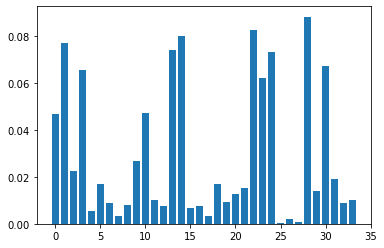

In [142]:
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',X_train.columns[i] ,' Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [143]:
importance=np.array(importance)

In [144]:
len(importance)

34

In [145]:
len(X_train.columns)

34

In [146]:
importance_map={}
for i in range(len(importance)):
    key=X_train.columns[i]
    value=importance[i]
    importance_map[key]=value

In [147]:
importance_map

{'caseyear': 0.046897712530329455,
 'statename': 0.0770380173826947,
 'veh_no': 0.02248278192937049,
 'vinyear': 0.06565470444491808,
 'vehtype_t': 0.005505569656317577,
 'bodystyl_t': 0.017063655981923408,
 'doors': 0.008918625532081838,
 'wheels': 0.0031267301337496766,
 'drivwhls': 0.00784183952592778,
 'mfg_t': 0.026696833067402205,
 'displci': 0.047397457413012496,
 'cylndrs': 0.00995857525748016,
 'fuel_t': 0.007401705212904798,
 'shipweight': 0.07398398900482435,
 'msrp': 0.07992668483769128,
 'drivetyp_t': 0.006562624518972175,
 'drl_t': 0.007528650306002246,
 'segmnt_t': 0.0033264283423140723,
 'plntctry_t': 0.017024035112559316,
 'origin_t': 0.009176193139572594,
 'vlvclndr': 0.012743178561990087,
 'vlvtotal': 0.015212954414141399,
 've_forms': 0.08247194765948702,
 'monthname': 0.062238564317128334,
 'hourname': 0.07314349820807696,
 'sch_busname': 0.0002680379760428811,
 'tow_vehname': 0.0021388692930685922,
 'spec_usename': 0.0005688594884678195,
 'age': 0.0883155433486973

In [148]:
import operator
sorted_importance = dict(sorted(importance_map.items(),
                            key=operator.itemgetter(1),
                            reverse=True))

In [281]:
sorted_importance

{'age': 0.0883155433486973,
 've_forms': 0.08247194765948702,
 'msrp': 0.07992668483769128,
 'statename': 0.0770380173826947,
 'shipweight': 0.07398398900482435,
 'hourname': 0.07314349820807696,
 'rest_usename': 0.0671434956471483,
 'vinyear': 0.06565470444491808,
 'monthname': 0.062238564317128334,
 'displci': 0.047397457413012496,
 'caseyear': 0.046897712530329455,
 'mfg_t': 0.026696833067402205,
 'veh_no': 0.02248278192937049,
 'drinkingname': 0.018989847819037165,
 'bodystyl_t': 0.017063655981923408,
 'plntctry_t': 0.017024035112559316,
 'vlvtotal': 0.015212954414141399,
 'sexname': 0.013968210576578693,
 'vlvclndr': 0.012743178561990087,
 'hispanicname': 0.010209922362172037,
 'cylndrs': 0.00995857525748016,
 'origin_t': 0.009176193139572594,
 'drugsname': 0.009074256997914767,
 'doors': 0.008918625532081838,
 'drivwhls': 0.00784183952592778,
 'drl_t': 0.007528650306002246,
 'fuel_t': 0.007401705212904798,
 'drivetyp_t': 0.006562624518972175,
 'vehtype_t': 0.005505569656317577,
 

In [150]:
selected_features=['age','ve_forms','statename','msrp','shipweight','hourname','vinyear','monthname','rest_usename','displci',
                   'caseyear','mfg_t','veh_no','plntctry_t','drinkingname','bodystyl_t','vlvtotal','sexname', 'cylndrs','doors',
                   'vlvclndr','hispanicname','drl_t','origin_t']

In [151]:
selected_features

['age',
 've_forms',
 'statename',
 'msrp',
 'shipweight',
 'hourname',
 'vinyear',
 'monthname',
 'rest_usename',
 'displci',
 'caseyear',
 'mfg_t',
 'veh_no',
 'plntctry_t',
 'drinkingname',
 'bodystyl_t',
 'vlvtotal',
 'sexname',
 'cylndrs',
 'doors',
 'vlvclndr',
 'hispanicname',
 'drl_t',
 'origin_t']

In [152]:
len(selected_features)

24

In [153]:
ethical=['age','ve_forms','statename','msrp','shipweight','vinyear','rest_usename','displci',
         'caseyear','mfg_t','veh_no','plntctry_t','bodystyl_t','vlvtotal', 'cylndrs','doors',
         'vlvclndr','drl_t','origin_t']

In [154]:
len(ethical)

19

<ipython-input-155-5b09e3ac1a79>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_oe, y_train_oe)


Feature: caseyear  Score: 0.00184
Feature: veh_no  Score: 0.00719
Feature: vinyear  Score: 0.00631
Feature: doors  Score: 0.00078
Feature: wheels  Score: 0.00043
Feature: drivwhls  Score: 0.00128
Feature: displci  Score: 0.00444
Feature: shipweight  Score: 0.00342
Feature: msrp  Score: 0.00356
Feature: vlvclndr  Score: 0.00181
Feature: vlvtotal  Score: 0.00219
Feature: ve_forms  Score: 0.02475
Feature: age  Score: 0.00418
Feature: statename_Alabama  Score: 0.00022
Feature: statename_Alaska  Score: 0.00003
Feature: statename_Arizona  Score: 0.00021
Feature: statename_Arkansas  Score: 0.00017
Feature: statename_California  Score: 0.00042
Feature: statename_Colorado  Score: 0.00023
Feature: statename_Connecticut  Score: 0.00006
Feature: statename_Delaware  Score: 0.00004
Feature: statename_District of Columbia  Score: 0.00001
Feature: statename_Florida  Score: 0.00052
Feature: statename_Georgia  Score: 0.00024
Feature: statename_Hawaii  Score: 0.00003
Feature: statename_Idaho  Score: 0.00

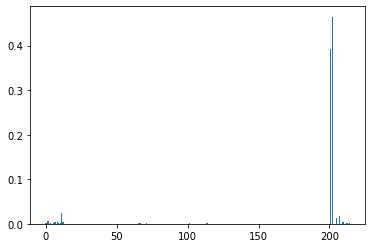

In [155]:
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train_oe, y_train_oe)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',X_train_oe.columns[i] ,' Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [156]:
X_train_le=X_train[ethical]

In [157]:
X_test_le=X_test[ethical]

In [158]:
X_test=X_test[selected_features]

In [159]:
X_train=X_train[selected_features]

In [160]:
X_train_le.shape

(161546, 19)

In [161]:
X_test_le.shape

(69234, 19)

In [162]:
y_train.shape

(161546, 1)

In [163]:
y_test.shape

(69234, 1)

In [164]:
y_train

,rollovername
295728,0
40645,1
351505,0
104849,0
295734,0
...,...
347138,0
233584,1
340613,1
87100,0


In [165]:
data_cc=data.copy()
data_eh = pd.get_dummies(data_cc[ethical])
target_cc=target.copy()
target_eh = pd.get_dummies(target_cc)

In [166]:
X_train_oe, X_test_oe, y_train_oe, y_test_oe=train_test_split(data_eh,target_eh,test_size=0.3)

In [167]:
X_train_oe

,age,ve_forms,msrp,shipweight,vinyear,displci,caseyear,veh_no,vlvtotal,doors,vlvclndr,statename_Alabama,statename_Alaska,statename_Arizona,statename_Arkansas,statename_California,statename_Colorado,statename_Connecticut,statename_Delaware,statename_District of Columbia,statename_Florida,statename_Georgia,statename_Hawaii,statename_Idaho,statename_Illinois,statename_Indiana,statename_Iowa,statename_Kansas,statename_Kentucky,statename_Louisiana,statename_Maine,statename_Maryland,statename_Massachusetts,statename_Michigan,statename_Minnesota,statename_Mississippi,statename_Missouri,statename_Montana,statename_Nebraska,statename_Nevada,statename_New Hampshire,statename_New Jersey,statename_New Mexico,statename_New York,statename_North Carolina,statename_North Dakota,statename_Ohio,statename_Oklahoma,statename_Oregon,statename_Pennsylvania,statename_Puerto Rico,statename_Rhode Island,statename_South Carolina,statename_South Dakota,statename_Tennessee,statename_Texas,statename_Utah,statename_Vermont,statename_Virginia,statename_Washington,statename_West Virginia,statename_Wisconsin,statename_Wyoming,rest_usename_Belt Used,rest_usename_Helmet Used,rest_usename_None Used,rest_usename_Restraint Used - Type Unknown,mfg_t_BMW,mfg_t_DAEWOO,mfg_t_DAIMLER-CHRYSLER,mfg_t_FCA,mfg_t_FIAT,mfg_t_FORD,mfg_t_GENERAL MOTORS,mfg_t_HONDA,mfg_t_HYUNDAI,mfg_t_ISUZU,mfg_t_KIA,mfg_t_MAZDA MOTOR CORPORATION,mfg_t_MCLAREN AUTOMOTIVE,mfg_t_MERCEDES-BENZ USA LLC,mfg_t_MITSUBISHI,mfg_t_NAVISTAR INTERNATIONAL,mfg_t_NISSAN,mfg_t_PORSCHE,mfg_t_SPARTAN MOTORS,mfg_t_SUBARU,mfg_t_SUZUKI,mfg_t_TOYOTA,mfg_t_VOLKSWAGEN,plntctry_t_Argentina,plntctry_t_Australia,plntctry_t_Austria,plntctry_t_Belgium,plntctry_t_Brazil,plntctry_t_Canada,"plntctry_t_China, People's Republic of",plntctry_t_Finland,plntctry_t_France,plntctry_t_GERMANY,plntctry_t_Germany,plntctry_t_Hungary,plntctry_t_India,plntctry_t_Italy,plntctry_t_Japan,"plntctry_t_Korea, Democratic People's Republic of","plntctry_t_Korea, Republic of",plntctry_t_Mexico,plntctry_t_Netherlands,plntctry_t_Poland,plntctry_t_Portugal,plntctry_t_Serbia and Montenegro,plntctry_t_Slovakia,plntctry_t_South Africa,plntctry_t_Spain,plntctry_t_Sweden,plntctry_t_Thailand,plntctry_t_Turkey,plntctry_t_United Kingdom,plntctry_t_United States,bodystyl_t_CAR,bodystyl_t_COUPE,bodystyl_t_INCOMPLETE,bodystyl_t_OTHER,bodystyl_t_SPORT,bodystyl_t_TRUCK,bodystyl_t_VAN,cylndrs_10.0,cylndrs_12.0,cylndrs_2.0,cylndrs_3.0,cylndrs_4.0,cylndrs_5.0,cylndrs_6.0,cylndrs_8.0,cylndrs_R,drl_t_AVAILABLE,drl_t_OPTIONAL,drl_t_STANDARD,origin_t_domestic,origin_t_domestic sponsored import,origin_t_import,origin_t_import built in north america
312927,68,2,33220.0,3519.0,2018.0,92.0,2018,1,16.0,4.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
163654,24,2,14532.0,3869.0,1997.0,262.0,2016,1,12.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
336257,38,3,36310.0,4540.0,2017.0,214.0,2018,2,24.0,4.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
123032,68,2,23255.0,3402.0,2015.0,146.0,2015,1,16.0,4.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
115217,87,2,22875.0,3780.0,1999.0,207.0,2015,2,0.0,4

In [168]:
y_test_oe

,rollovername
276118,0
54151,0
442963,0
595,1
196934,0
...,...
340829,0
285299,0
150904,0
331833,0


#  Part-6: Training and Performance Evaluation

> You need to determine a score which is proper for the learning task and the distribution of target variable to benchmark the models. Note that even a model is successful for a target metric, it might performs poorly in terms of other performance scores. So, you should observe multiple metrics. <br>
> **Hint:** Think about which type of error made in predictions is more harmful from a car insurance business perspective: False negative  or false positive predictions? <br>

> According EDA done in the previous parts, you might need to adress any imbalanced dataset problem. (Not expected to use advanced methods or to do an extensive experimentation) <br>
**Hint**: Inspect model parameters which are related to class weightening or loss weightening.

> You have three Naive-Bayes-based model options for benchmarking with other types of models: ```GaussianNB```, ```CategoricalNB```, and ```ComplementNB```.
Read the descriptions provided in Sklearn library or search them on the Internet, and choose one of them regarding which sounds more reasonable considering the dataset characteristics and the learning task.<br>
**BONUS**: Experiment a simple prediction technique ensembling multiple Naive-Bayes models. (not required)

In [169]:
#YOUR CODE HERE
scaler = StandardScaler()
X_train_le_std = scaler.fit_transform(X_train_le)
X_test_le_std = scaler.transform(X_test_le)

# Support Vector Machine (SVM)

In [349]:
svc=SVC(kernel="linear",C=0.1)

In [350]:
svc.fit(X_train_le_std, y_train.values.ravel())

SVC(C=0.1, kernel='linear')

In [351]:
pred_y_train =svc.predict(X_train_le_std)
pred_y_test = svc.predict(X_test_le_std)

In [352]:
#Creating the classification report
print("TRAIN SVM")
print(classification_report(y_train, pred_y_train))

TRAIN SVM
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    132837
           1       0.00      0.00      0.00     28709

    accuracy                           0.82    161546
   macro avg       0.41      0.50      0.45    161546
weighted avg       0.68      0.82      0.74    161546



C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [353]:
#Creating the classification report
print("TEST SVM")
print(classification_report(y_test, pred_y_test))

TEST SVM
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     56998
           1       0.00      0.00      0.00     12236

    accuracy                           0.82     69234
   macro avg       0.41      0.50      0.45     69234
weighted avg       0.68      0.82      0.74     69234



C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [354]:
svc_cm=confusion_matrix(y_test, svc.predict(X_test_le))

In [425]:
disp=ConfusionMatrixDisplay(confusion_matrix=svc_cm)

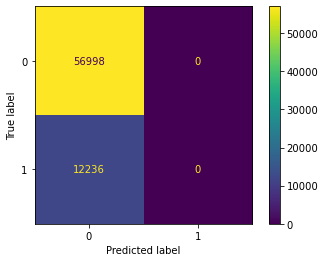

In [426]:
disp.plot()

In [357]:
svc_score=svc.score(X_test_le,y_test)

In [358]:
svc_score

0.8232660253632609

# Naive Bayes 

## Gaussian Naive Bayes

In [430]:
gnb = GaussianNB()

In [431]:
gnb.fit(X_train_le_std, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [432]:
pred_y_train = gnb.predict(X_train_le_std)
pred_y_test = gnb.predict(X_test_le_std)

In [433]:
#Creating the classification report
print("TRAIN GaussianNB")
print(classification_report(y_train, pred_y_train))

TRAIN GaussianNB
              precision    recall  f1-score   support

           0       0.91      0.65      0.76    132837
           1       0.31      0.71      0.43     28709

    accuracy                           0.66    161546
   macro avg       0.61      0.68      0.60    161546
weighted avg       0.81      0.66      0.70    161546



In [434]:
#Creating the classification report
print("TEST GaussianNB")
print(classification_report(y_test, pred_y_test))

TEST GaussianNB
              precision    recall  f1-score   support

           0       0.91      0.65      0.76     56998
           1       0.31      0.72      0.43     12236

    accuracy                           0.66     69234
   macro avg       0.61      0.68      0.59     69234
weighted avg       0.81      0.66      0.70     69234



In [188]:
gnb_cm=confusion_matrix(y_test, gnb.predict(X_test_le))

In [189]:
disp=ConfusionMatrixDisplay(confusion_matrix=gnb_cm)

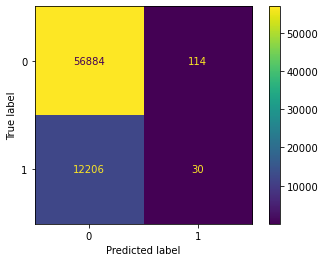

In [190]:
disp.plot()

In [191]:
gnb_score=gnb.score(X_test_le_std,y_test)

In [192]:
gnb_score

0.6612646965363839

## Categorical Naive Bayes 

In [331]:
scaler_mm = MinMaxScaler()
X_train_le_mm = scaler_mm.fit_transform(X_train_le)
X_test_le_mm = scaler_mm.transform(X_test_le)

In [332]:
cn=CategoricalNB(alpha=1)

In [333]:
cn.fit(X_train_le_mm, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CategoricalNB(alpha=1)

In [435]:
pred_y_train = cn.predict(X_train_le_mm)
pred_y_test = cn.predict(X_test_le_mm)

In [436]:
cn_score=cn.score(X_test_le_mm,y_test)

In [437]:
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    132837
           1       0.45      0.00      0.01     28709

    accuracy                           0.82    161546
   macro avg       0.63      0.50      0.45    161546
weighted avg       0.76      0.82      0.74    161546



In [438]:
print("TEST CategoricalNB")
print(classification_report(y_test, pred_y_test))

TEST CategoricalNB
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     56998
           1       0.53      0.00      0.01     12236

    accuracy                           0.82     69234
   macro avg       0.68      0.50      0.45     69234
weighted avg       0.77      0.82      0.74     69234



In [340]:
cn_cm=confusion_matrix(y_test, cn.predict(X_test_le_mm))

In [342]:
disp=ConfusionMatrixDisplay(confusion_matrix=cn_cm)

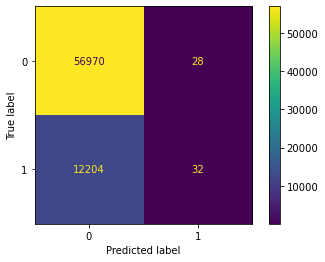

In [343]:
disp.plot()

## Complement Naive Bayes

In [205]:
cnb=ComplementNB()

In [206]:
scaler = MinMaxScaler()
X_train_le_mm = scaler.fit_transform(X_train_le)
X_test_le_mm = scaler.transform(X_test_le)

In [207]:
cnb.fit(X_train_le_mm, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ComplementNB()

In [439]:
pred_y_train = cnb.predict(X_train_le_mm)
pred_y_test = cnb.predict(X_test_le_mm)

In [440]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.66      0.77    132837
           1       0.30      0.67      0.42     28709

    accuracy                           0.67    161546
   macro avg       0.60      0.67      0.59    161546
weighted avg       0.80      0.67      0.70    161546



In [441]:
#Creating the classification report
print("TEST ComplementNB")
print(classification_report(y_test, pred_y_test))

TEST ComplementNB
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     56998
           1       0.30      0.67      0.41     12236

    accuracy                           0.66     69234
   macro avg       0.60      0.67      0.59     69234
weighted avg       0.80      0.66      0.70     69234



In [211]:
cnb_cm=confusion_matrix(y_test, cnb.predict(X_test_le))

In [212]:
disp=ConfusionMatrixDisplay(confusion_matrix=cnb_cm)

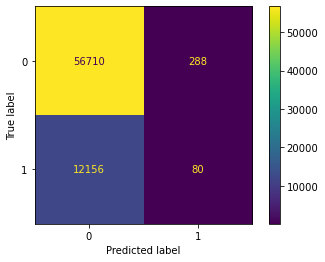

In [213]:
disp.plot()

In [214]:
cnb_score=cnb.score(X_test_le_mm,y_test)

In [215]:
cnb_score

0.6639512378311234

# Logistic Regression

In [291]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train_le_std, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(n_jobs=-1)

In [442]:
pred_y_train = lr.predict(X_train_le_std)
pred_y_test = lr.predict(X_test_le_std)

In [443]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    132837
           1       0.64      0.25      0.36     28709

    accuracy                           0.84    161546
   macro avg       0.75      0.61      0.63    161546
weighted avg       0.82      0.84      0.81    161546



In [444]:
#Creating the classification report
print("TEST LogisticRegression")
print(classification_report(y_test, pred_y_test))

TEST LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     56998
           1       0.64      0.24      0.35     12236

    accuracy                           0.84     69234
   macro avg       0.75      0.61      0.63     69234
weighted avg       0.82      0.84      0.81     69234



In [295]:
from sklearn.metrics import confusion_matrix
lr_cm=confusion_matrix(y_test, lr.predict(X_test_le))

In [296]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(confusion_matrix=lr_cm)

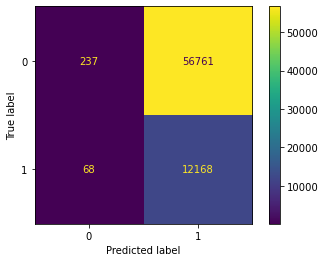

In [297]:
disp.plot()

In [298]:
lr_score=lr.score(X_test_le_std,y_test)

In [299]:
lr_score

0.8414218447583557

In [300]:
accuracy_score_lr=accuracy_score(y_test, pred_y_test)

In [301]:
accuracy_score_lr

0.8414218447583557

In [225]:
scaler = StandardScaler()
X_train_oe_std = scaler.fit_transform(X_train_oe)
X_test_oe_std = scaler.transform(X_test_oe)

In [226]:
lr_o = LogisticRegression(n_jobs=-1)
lr_o.fit(X_train_oe_std, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(n_jobs=-1)

In [227]:
pred_y_train = lr_o.predict(X_train_oe_std)
pred_y_test = lr_o.predict(X_test_oe_std)

In [228]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    132837
           1       0.00      0.00      0.00     28709

    accuracy                           0.82    161546
   macro avg       0.41      0.50      0.45    161546
weighted avg       0.68      0.82      0.74    161546



In [229]:
#Creating the classification report
print("TEST")
print(classification_report(y_test, pred_y_test))

TEST
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     56998
           1       1.00      0.00      0.00     12236

    accuracy                           0.82     69234
   macro avg       0.91      0.50      0.45     69234
weighted avg       0.85      0.82      0.74     69234



In [230]:
lr_o_cm=confusion_matrix(y_test, lr_o.predict(X_test_oe))

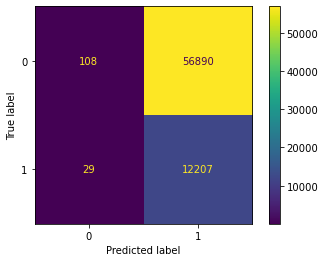

In [231]:
disp=ConfusionMatrixDisplay(confusion_matrix=lr_o_cm)
disp.plot()

In [232]:
lr_o_score=lr_o.score(X_test_oe_std,y_test)

In [233]:
lr_o_score

0.8232804691336627

In [234]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [235]:
lr1 = LogisticRegression(n_jobs=-1)
lr1.fit(X_train_std, y_train)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(n_jobs=-1)

In [236]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    132837
           1       0.00      0.00      0.00     28709

    accuracy                           0.82    161546
   macro avg       0.41      0.50      0.45    161546
weighted avg       0.68      0.82      0.74    161546



In [237]:
#Creating the classification report
print("TEST")
print(classification_report(y_test, pred_y_test))

TEST
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     56998
           1       1.00      0.00      0.00     12236

    accuracy                           0.82     69234
   macro avg       0.91      0.50      0.45     69234
weighted avg       0.85      0.82      0.74     69234



In [238]:
lr1_cm=confusion_matrix(y_test, lr1.predict(X_test))

In [239]:
disp=ConfusionMatrixDisplay(confusion_matrix=lr1_cm)

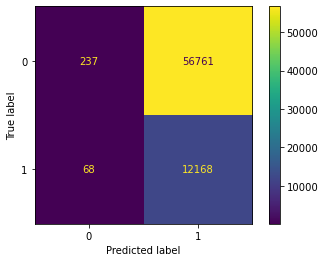

In [240]:
disp.plot()

In [241]:
lr1_score=lr1.score(X_test_std,y_test)

In [242]:
lr1_score

0.8399341364069677

# Random Forest

In [446]:
rf = RandomForestClassifier(criterion="entropy",n_estimators=100, max_depth=10)

In [447]:
rf.fit(X_train_le_std, y_train)

<ipython-input-447-a87f6fda41bb>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_le_std, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10)

In [448]:
pred_y_train = rf.predict(X_train_le_std)
pred_y_test = rf.predict(X_test_le_std)

In [449]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    132837
           1       0.69      0.28      0.40     28709

    accuracy                           0.85    161546
   macro avg       0.78      0.63      0.66    161546
weighted avg       0.83      0.85      0.82    161546



In [450]:
#Creating the classification report
print("TEST RandomForest")
print(classification_report(y_test, pred_y_test))

TEST RandomForest
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     56998
           1       0.65      0.26      0.38     12236

    accuracy                           0.85     69234
   macro avg       0.76      0.62      0.64     69234
weighted avg       0.82      0.85      0.82     69234



In [451]:
rf_cm=confusion_matrix(y_test, rf.predict(X_test_le))
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm)

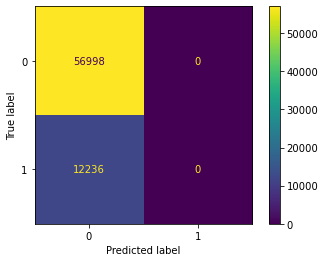

In [452]:
disp.plot()

In [386]:
rf_score=rf.score(X_test_le_std,y_test)

In [387]:
rf_score

0.8452783314556431

> Plot training and testing performance of all models with a bar chart.

In [388]:
accuracy_score?

In [422]:
acc_scores_test=[svc_score,gnb_score,cn_score,cnb_score,lr_score,rf_score]

In [423]:
acc_scores_test

[0.8232660253632609,
 0.6612646965363839,
 0.8233238004448681,
 0.6639512378311234,
 0.8414218447583557,
 0.8452783314556431]

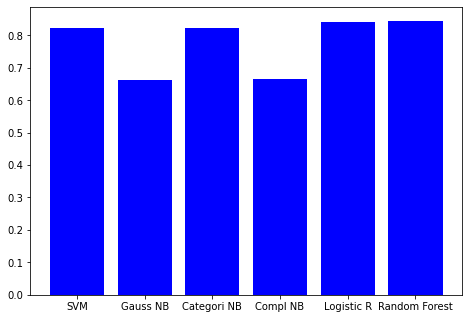

In [424]:
#YOUR CODE HERE
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['SVM', 'Gauss NB', 'Categori NB','Compl NB', 'Logistic R', 'Random Forest']
ax.bar(models,acc_scores_test,color = 'b')
plt.show()


# Part-7: Interpretation
7.1) Visualize rollover risk distributions of the models for training and testing datasets separately. Report the visual results.<br>
**Hint**: Use ```predict_proba``` function of the fitted models.

In [253]:
# YOUR CODE HERE

In [254]:
lr_probabilities=lr.predict_proba(X_test_le_std)

In [255]:
lr_probabilities_positive=lr_probabilities[:,1]

In [256]:
from sklearn.metrics import roc_auc_score, roc_curve

In [257]:
lr_auc=roc_auc_score(y_test,lr_probabilities_positive)

In [258]:
nonskilled_probilities=[0 for _ in range(len(y_test))]

In [259]:
ns_auc=roc_auc_score(y_test,nonskilled_probilities)

In [260]:
lr_fpr, lr_tpr, lr_thresholds=roc_curve(y_test,lr_probabilities_positive)

In [261]:
ns_fpr, ns_tpr, ns_thresholds=roc_curve(y_test,nonskilled_probilities)

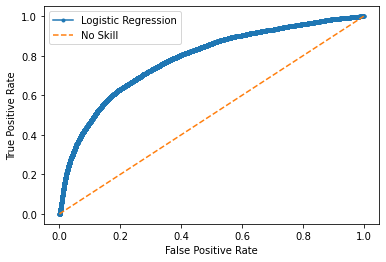

In [262]:
plt.plot(lr_fpr, lr_tpr, marker='.',label="Logistic Regression")
plt.plot(ns_fpr, ns_tpr, linestyle="--",label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [284]:
clf = LogisticRegression().fit(X_test_le_std, y_test)
result = permutation_importance(clf, X_test_le_std, y_test, n_repeats=10)

C:\Users\aylin.LAPTOP-TJ9MCDMK\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [285]:
result

{'importances_mean': array([ 9.74954502e-04,  1.77672820e-02, -8.66626224e-05,  7.79963602e-05,
        -7.36632290e-05,  4.35046365e-03,  2.21928532e-02, -1.38660196e-04,
        -2.59987867e-04,  3.56761129e-04,  3.80160037e-03,  5.79195193e-04,
         8.61282029e-03, -2.23878441e-04,  4.18869342e-05, -2.88875408e-05,
         7.23632897e-04, -1.63214606e-04, -2.29655949e-04]),
 'importances_std': array([2.98273476e-04, 5.31893684e-04, 4.33313112e-05, 2.26283688e-04,
        1.21267474e-04, 3.22053977e-04, 2.99390478e-04, 1.39320629e-04,
        9.27105557e-05, 1.13922807e-04, 5.03828857e-04, 1.49051033e-04,
        3.97560681e-04, 7.34363106e-05, 3.50540518e-05, 2.14235736e-05,
        2.53935286e-04, 8.97491775e-05, 1.88373569e-04]),
 'importances': array([[ 6.21082127e-04,  1.02550770e-03,  9.96620158e-04,
          1.02550770e-03,  1.50215212e-03,  8.81069995e-04,
          1.48770835e-03,  6.35525898e-04,  8.95513765e-04,
          6.78857209e-04],
        [ 1.75202935e-02,  1

7.2) Visualize year-by-year rollover risk distributions by the predictions of the best model you determined. Interpret the results in the report.

In [263]:
# YOUR CODE HERE

7.3) Determine the features which useful to explain the car rollover phenomenon.<br>
**Reminder**: Determine **at most 30** features. It is not saying that report 30 features. Maybe, after the top 20 features, others have much less importance. You should report a short-listed features.

You can follow several strategies:
- Using ```coef_``` attribute of linear models
- Using ```feature_log_prob_``` attribute of probabilistic models
- Using ```feature_importances_``` attribute of the decision-tree based models
- Using ```permutation_importance``` function of sklearn (**REQUIRED** to explain how it works in the report)
    
You can either rely on the best model or all models to determine the good features.
For example, if you have multiple successful models, you can determine the common important features for them. 
    
After the creating a short-listed features, you can ensure whether they are enough to explain the phenemona via observing performances of re-trained model(s) using only these features.

In [264]:
# YOUR CODE HERE

In [365]:
lr.coef_

array([[-2.53543396e-01, -1.73897360e+00,  1.78912138e-02,
         5.73833651e-02,  3.09109938e-02, -1.89706317e-01,
         4.96496345e-01,  5.99094156e-04, -2.18650663e-02,
         5.97306286e-02, -3.16024657e-01,  5.52843161e-02,
         2.52807353e-01, -2.19314066e-03, -1.53102984e-03,
         1.49828303e-02, -8.65992620e-02,  1.78380084e-03,
        -5.15152457e-02]])

In [359]:
rf_importance=rf.feature_importances_

In [360]:
rf_importance

array([0.03425367, 0.33871574, 0.02129463, 0.02459625, 0.02779505,
       0.05826337, 0.2367072 , 0.033913  , 0.00749056, 0.00983885,
       0.09938252, 0.00781648, 0.05224423, 0.01126843, 0.00754041,
       0.00561865, 0.01719383, 0.00221662, 0.00385052])

Feature: age  Score: 0.03425
Feature: ve_forms  Score: 0.33872
Feature: statename  Score: 0.02129
Feature: msrp  Score: 0.02460
Feature: shipweight  Score: 0.02780
Feature: vinyear  Score: 0.05826
Feature: rest_usename  Score: 0.23671
Feature: displci  Score: 0.03391
Feature: caseyear  Score: 0.00749
Feature: mfg_t  Score: 0.00984
Feature: veh_no  Score: 0.09938
Feature: plntctry_t  Score: 0.00782
Feature: bodystyl_t  Score: 0.05224
Feature: vlvtotal  Score: 0.01127
Feature: cylndrs  Score: 0.00754
Feature: doors  Score: 0.00562
Feature: vlvclndr  Score: 0.01719
Feature: drl_t  Score: 0.00222
Feature: origin_t  Score: 0.00385


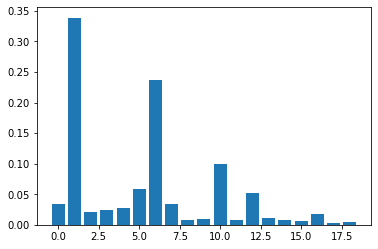

In [374]:
for i,v in enumerate(rf_importance):
    print('Feature:',X_train_le.columns[i] ,' Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(rf_importance))], rf_importance)
pyplot.show()

In [375]:
rf_importance=np.array(rf_importance)

In [376]:
importance_map={}
for i in range(len(rf_importance)):
    key=X_train_le.columns[i]
    value=rf_importance[i]
    importance_map[key]=value

In [377]:
sorted_importance = dict(sorted(importance_map.items(),
                            key=operator.itemgetter(1),
                            reverse=True))

In [378]:
sorted_importance

{'ve_forms': 0.3387157378945583,
 'rest_usename': 0.2367071973748578,
 'veh_no': 0.09938252040276406,
 'vinyear': 0.058263366408765865,
 'bodystyl_t': 0.05224422853989592,
 'age': 0.034253673841446994,
 'displci': 0.03391299735404212,
 'shipweight': 0.027795054894025163,
 'msrp': 0.024596249717478137,
 'statename': 0.02129463209799208,
 'vlvclndr': 0.017193828061894054,
 'vlvtotal': 0.011268432258877591,
 'mfg_t': 0.009838847992850692,
 'plntctry_t': 0.007816476692823078,
 'cylndrs': 0.007540405176818782,
 'caseyear': 0.007490561523510552,
 'doors': 0.005618650872146611,
 'origin_t': 0.0038505223179505724,
 'drl_t': 0.002216616577301524}

In [394]:
shortest=['ve_forms','rest_usename','veh_no','vinyear','bodystyl_t']

In [420]:
shortest

['ve_forms', 'rest_usename', 'veh_no', 'vinyear', 'bodystyl_t']

In [401]:
x=X_train_le[shortest]
x_test=X_test_le[shortest]

In [402]:
scaler = StandardScaler()
X_std = scaler.fit_transform(x)
x_test_std = scaler.transform(x_test)

In [411]:
rf2 = RandomForestClassifier(criterion="entropy",n_estimators=100, max_depth=10)

In [412]:
rf2.fit(X_std, y_train)

<ipython-input-412-b3d065eeb7f9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(X_std, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10)

In [413]:
pred_y_train = rf2.predict(X_std)
pred_y_test = rf2.predict(x_test_std)

In [414]:
#Creating the classification report
print("TRAIN")
print(classification_report(y_train, pred_y_train))

TRAIN
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    132837
           1       0.64      0.28      0.39     28709

    accuracy                           0.84    161546
   macro avg       0.75      0.62      0.65    161546
weighted avg       0.82      0.84      0.82    161546



In [415]:
#Creating the classification report
print("TEST")
print(classification_report(y_test, pred_y_test))

TEST
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     56998
           1       0.63      0.27      0.38     12236

    accuracy                           0.84     69234
   macro avg       0.75      0.62      0.64     69234
weighted avg       0.82      0.84      0.82     69234



In [417]:
rf2_score=rf2.score(x_test_std,y_test)

In [418]:
rf2_score

0.8431839847473784

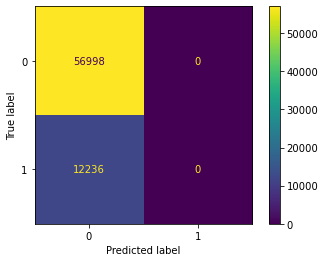

In [419]:
rf2_cm=confusion_matrix(y_test, rf2.predict(x_test))
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()